### `KDE` Tutorial ( https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html )

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(20)

# -----------------------------------------------------------------------------------

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
hist1 = ax1.hist(x, bins=1000, density=True)
density, bins, patches = hist1

# -----------------------------------------------------------------------------------

# bins = np.linspace(-5, 10, 10)

# fig, ax = plt.subplots(1, 2, figsize=(12, 4),
#                        sharex=True, sharey=True,
#                        subplot_kw={'xlim':(-4, 9),
#                                    'ylim':(-0.02, 0.3)})
# fig.subplots_adjust(wspace=0.05)
# for i, offset in enumerate([0.0, 0.6]):
#     ax[i].hist(x, bins=bins + offset, density=True)
#     ax[i].plot(x, np.full_like(x, -0.01), '|k',
#                markeredgewidth=1)

# -----------------------------------------------------------------------------------

# fig, ax = plt.subplots()
# bins = np.arange(-3, 8)
# ax.plot(x, np.full_like(x, -0.1), '|k',
#         markeredgewidth=1)
# for count, edge in zip(*np.histogram(x, bins)):
#     for i in range(count):
#         ax.add_patch(plt.Rectangle((edge, i), 1, 1,
#                                    alpha=0.5))
# ax.set_xlim(-4, 8)
# ax.set_ylim(-0.2, 8)

# -----------------------------------------------------------------------------------

# x_d = np.linspace(-4, 8, 2000)
# density = sum((abs(xi - x_d) < 0.5) for xi in x)

# plt.fill_between(x_d, density, alpha=0.5)
# plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

# plt.axis([-4, 8, -0.2, 8])

# -----------------------------------------------------------------------------------

from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
ax2.fill_between(x_d, density, alpha=0.5)
ax2.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

ax2.axis([-4, 8, -0.2, 5])

### `KDE` using `Surface Area`

In [ ]:
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity

xlsx_path = r"C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\{Data}_Processed\{20230424_Update}_Academia_Sinica_i505\{Modify}_xlsx\{3CLS_BY_SurfStDev}_data.xlsx"
df_input_xlsx :pd.DataFrame = pd.read_excel(xlsx_path, engine = 'openpyxl')

surface_area = df_input_xlsx["Trunk surface area, SA (um2)"]
surface_area = surface_area.to_numpy()
log_sa = np.log10(surface_area)

hist = plt.hist(log_sa, bins=1000, density=True)
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
print((density * widths).sum())


# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=0.01178167723136119, kernel='gaussian')
kde.fit(log_sa[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(bins[:, None])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.fill_between(bins, np.exp(logprob), alpha=0.5)
# ax.plot(bins, np.exp(logprob), label='KDE')
# ax.plot(log_sa, np.full_like(log_sa, -0.01), '|k', markeredgewidth=1)

In [ ]:
from sklearn.cluster import KMeans

# 假設已經有了一個KDE模型 kde

# 得到KDE的機率密度值
logprob = kde.score_samples(bins[:, None])
density = np.exp(logprob)

# 使用KMeans將資料分成兩群
kmeans = KMeans(n_clusters=2, random_state=0).fit(log_sa[:, None])
print(kmeans.cluster_centers_)

plt.figure(fig)
ax = plt.gca()  # 取得目前選取的圖的軸物件
for c in kmeans.cluster_centers_:
    ax.axvline(x=c, color='k', linestyle='--')

# Assign a color to each data point based on its cluster label
colors = ['r' if label == 0 else 'b' for label in kmeans.labels_]

# Scatter plot of the data colored by cluster label
ax.scatter(log_sa, np.zeros_like(log_sa), c=colors, alpha=0.5, label='KMeans clusters')

# Set the plot title and legend
ax.set_title('KDE with KMeans Clusters')
ax.legend()

# Display the plot
plt.show()

### Find best `bandwidth`

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-2, 2, 10000)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(log_sa[:, None])

print(bandwidths)
grid.best_params_

### Run

In [1]:
import os
import sys
import re
from typing import List
from pathlib import Path
from copy import deepcopy
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

sys.path.append("./../../modules/") # add path to scan customized module
from fileop import create_new_dir

# -----------------------------------------------------------------------------------

class SurfaceAreaKMeansCluster():
    
    def __init__(self, xlsx_path:Path, n_clusters:int, label_str:List[str], rand_seed:int, with_kde:bool, sheet_name:str=None) -> None:
        
        if isinstance(xlsx_path, Path): self.xlsx_path = xlsx_path
        else: raise TypeError("xlsx_path should be a 'Path' object, please using `from pathlib import Path`")
        self.xlsx_path_split_list = str(self.xlsx_path).split(os.sep)
        self.sheet_name = sheet_name
        self.xlsx_df = None
        self.surface_area = None
        
        self.n_clusters = n_clusters
        self.label_str = label_str # small -> big, e.g. ["S", "M", "L"]
        self.rand_seed = rand_seed
        self.with_kde = with_kde
        
        self.show_old_classdiv = None
        self.old_classdiv_info_dict = {}
        self.cluster_img_dir = None
        self.cluster_img_kde_dir = None
        
        self.sinica_idx = None # { Reminder }_Academia_Sinica_i[num_RGB]
        self.cluster_xlsx_dir = None
        self.cluster_xlsx_name = f"{self.n_clusters}CLS_SURF_KMeans_RND{self.rand_seed}"
        self.cluster_xlsx_path = None
        self.clustered_xlsx_df = None
        
        self.fig = None
        self.ax = None
        self.fig_name = None
        self.bins = None
        self.clusters_pt_y_pos = None # misc
        self.digits = None # misc
        
        self.kde = None
        self.kmeans = KMeans(n_clusters = self.n_clusters, random_state=self.rand_seed)
        self.kmeans_centers = None
        self.y_kmeans = None # predict
        
        self.surf2pred_dict = None
        self.clusters_max_area = [0]*n_clusters
        self.label_idx2str = None
        
        self._find_sinica_dir_in_path()
        self.dataset_id = self.xlsx_path_split_list[self.sinica_idx].split("_")[-1]
        
        self.init_figure()
        self.plot_misc_settings()
    
    
    def __repr__(self):
        return (f'self.dataset_id  : {self.dataset_id}\n'
                f'self.xlsx_path   : {self.xlsx_path}\n'
                f'self.n_clusters  : {self.n_clusters}\n'
                f'self.label_str   : {self.label_str}\n'
                f'self.rand_seed   : {self.rand_seed}\n'
                f'self.with_kde    : {self.with_kde}\n'
                f'self.sheet_name  : {self.sheet_name}\n'
                )
    
    
    def _find_sinica_dir_in_path(self):
        self.show_old_classdiv = "CLS" in self.xlsx_path_split_list[-1]
        for i, text in enumerate(self.xlsx_path_split_list):
            if "Academia_Sinica" in text: self.sinica_idx = i
    
    
    def init_cluster_xlsx_saveplace(self):
        self.cluster_xlsx_dir = Path( os.sep.join(self.xlsx_path_split_list[:(self.sinica_idx+1)]) ) / r"{Modify}_xlsx"
        self.cluster_xlsx_path = self.cluster_xlsx_dir / f"{{{self.cluster_xlsx_name}}}_data.xlsx"
        create_new_dir(str(self.cluster_xlsx_dir), display_in_CLI=False)
    
    
    def init_cluster_img_saveplace(self):
        self.cluster_img_dir = Path( f"./k_means/cluster/" ).joinpath(self.dataset_id)
        self.cluster_img_kde_dir = Path( f"./k_means/cluster_with_kde/" ).joinpath(self.dataset_id)
        create_new_dir(str(self.cluster_img_dir), display_in_CLI=False)
        create_new_dir(str(self.cluster_img_kde_dir), display_in_CLI=False)
    
    
    def read_xlsx(self):
        if self.show_old_classdiv: self.xlsx_df :pd.DataFrame = pd.read_excel(self.xlsx_path, engine = 'openpyxl', sheet_name=self.sheet_name)
        else: self.xlsx_df :pd.DataFrame = pd.read_excel(self.xlsx_path, engine = 'openpyxl')
        

    def extract_surface_area(self):
        self.surface_area = self.xlsx_df["Trunk surface area, SA (um2)"].to_numpy()
        if self.with_kde: self.surface_area = np.log10(self.surface_area[:, None])
        else: self.surface_area = self.surface_area[:, None]
    
    
    def get_old_classdiv_info(self):
        if self.with_kde: 
            self.old_classdiv_info_dict['L_std_value'] = np.log10(self.xlsx_df["L_1s"][0])
            self.old_classdiv_info_dict['avg_value'] = np.log10(self.xlsx_df["average"][0])
            self.old_classdiv_info_dict['R_std_value'] = np.log10(self.xlsx_df["R_1s"][0])
        else: 
            self.old_classdiv_info_dict['L_std_value'] = self.xlsx_df["L_1s"][0]
            self.old_classdiv_info_dict['avg_value'] = self.xlsx_df["average"][0]
            self.old_classdiv_info_dict['R_std_value'] = self.xlsx_df["R_1s"][0]
    
    
    def init_figure(self):
        self.fig = plt.figure(figsize=(12.8, 7.2), dpi=200)
        self.ax = self.fig.add_subplot(1, 1, 1)
        if self.show_old_classdiv: self.fig_name = f"{self.dataset_id}, {self.cluster_xlsx_name}, {self.sheet_name}"
        else: self.fig_name = f"{self.dataset_id}, {self.cluster_xlsx_name}"
        self.fig.suptitle(self.fig_name, size=20)
        self.fig.subplots_adjust(top=0.9)
    
    
    def plot_hist(self):
        hist = self.ax.hist(self.surface_area, bins=100, density=True, alpha=0.7)
        density, self.bins, patches = hist
        widths = self.bins[1:] - self.bins[:-1]
        print(f"p = {(density * widths).sum()}\n")
    
    
    def gen_kde(self):
        # instantiate and fit the KDE model
        self.kde = KernelDensity(bandwidth=0.01178167723136119, kernel='gaussian')
        self.kde.fit(self.surface_area)

        # score_samples returns the log of the probability density
        logprob = self.kde.score_samples(self.bins[:, None])

        self.ax.fill_between(self.bins, np.exp(logprob), alpha=0.5, color="orange")
        # self.ax.plot(self.bins, np.exp(logprob), label='KDE', color="orange") # , linestyle='--'
    
    
    def gen_kmeans(self):
        self.kmeans.fit(self.surface_area)
        self.kmeans_centers = self.kmeans.cluster_centers_ # 群心
        print(f'kmeans_centers {type(self.kmeans_centers)}: \n{self.kmeans_centers}\n')
        self.y_kmeans = self.kmeans.predict(self.surface_area) # 分群
    
    
    def gen_surf2pred_dict(self):
        self.surf2pred_dict = { area : label for area, label in zip(self.surface_area.squeeze(), self.y_kmeans)}
    
    
    def find_cluster_max_area(self):
        for area, label in self.surf2pred_dict.items():
            if area > self.clusters_max_area[label]:
                self.clusters_max_area[label] = area
        print(f'self.clusters_max_area {type(self.clusters_max_area)}: {self.clusters_max_area}\n')
    
    
    def gen_clustered_xlsx_df(self):
        max_area_dict = { cluster: max_area for cluster, max_area in enumerate(self.clusters_max_area)}
        max_area_dict = OrderedDict(sorted(list(max_area_dict.items()), key=lambda x: x[1]))
        self.label_idx2str = { cls_idx: cls_str for (cls_idx, _), cls_str in zip(max_area_dict.items(), self.label_str) }
        print(f'label_idx2str {type(self.label_idx2str)}: {self.label_idx2str}\n')

        col_class_dict = deepcopy(self.surf2pred_dict)
        for area, label in col_class_dict.items():
            col_class_dict[area] = self.label_idx2str[label]
        col_class_series = pd.Series(list(col_class_dict.values()), name="class")
        self.clustered_xlsx_df = pd.concat([self.xlsx_df, col_class_series], axis=1)

    
    def plot_misc_settings(self):
        if self.with_kde: self.clusters_pt_y_pos = -0.5
        else: self.clusters_pt_y_pos = -2e-7
        
        if self.with_kde: self.digits = 8
        else: self.digits = 2
    
    
    def plot_clusters(self):
        self.ax.plot(self.surface_area, np.full_like(self.surface_area, self.clusters_pt_y_pos*0.4), '|k', 
                     markeredgewidth=1)
        self.ax.scatter(
            self.surface_area, np.full_like(self.surface_area, self.clusters_pt_y_pos),
            c = self.y_kmeans,    # 指定標記
            edgecolor = 'none',   # 無邊框
            # alpha = 0.5         # 不透明度
            cmap="viridis"
        )
    
    
    def plot_cluster_center(self):
        self.ax.scatter(self.kmeans_centers.reshape(-1), 
                        np.full_like(self.kmeans_centers.reshape(-1), self.clusters_pt_y_pos),
                        marker="x", s=50, color="black")
    
    
    def plot_cluster_boundary(self):
        for max_area in self.clusters_max_area:
            self.ax.axvline(x=max_area, color='k', linestyle='--')
            self.ax.text(max_area, 0.9, f'x={max_area:.{self.digits}f}  ', 
                         transform=self.ax.get_xaxis_transform(), ha='right', 
                         color='black',
                         path_effects=[path_effects.withSimplePatchShadow(offset=(0.5, -0.5), linewidth=1, foreground='black')])
    
    
    def plot_old_classdiv_boundary(self):
        for i, (key, value) in enumerate(self.old_classdiv_info_dict.items()):
            self.ax.axvline(x=value, color='r', linestyle='--', alpha=0.5)
            self.ax.text(value, 0.23*(i+1), f'   {key}:\n   {value:.{self.digits}f}', 
                         transform=self.ax.get_xaxis_transform(), ha='left',
                         color='red', alpha=0.5,
                         path_effects=[path_effects.withSimplePatchShadow(offset=(0.5, -0.5), linewidth=1, foreground='black')])

    
    def save_fig(self):
        if self.with_kde:
            if self.show_old_classdiv: self.fig.savefig(str(self.cluster_img_kde_dir/ f"{self.fig_name}.png" ))
            else: self.fig.savefig(str(self.cluster_xlsx_dir/ f"{{{self.cluster_xlsx_name}}}_kde.png" ))
        else:
            if self.show_old_classdiv: self.fig.savefig(str(self.cluster_img_dir/ f"{self.fig_name}.png" ))
            else: self.fig.savefig(str(self.cluster_xlsx_dir/ f"{{{self.cluster_xlsx_name}}}.png" ))
    
    
    def save_clustered_xlsx_df(self):
        self.clustered_xlsx_df.to_excel(str(self.cluster_xlsx_path), engine="openpyxl", index=False)

    
    def compare_to_old_classdiv(self):
        self.init_cluster_img_saveplace()
        self.read_xlsx()
        self.extract_surface_area()
        self.get_old_classdiv_info()
        self.plot_hist()
        if self.with_kde: self.gen_kde()
        self.gen_kmeans()
        self.gen_surf2pred_dict()
        self.find_cluster_max_area()
        self.plot_clusters()
        self.plot_cluster_center()
        self.plot_cluster_boundary()
        self.plot_old_classdiv_boundary()
        self.save_fig()
    
    
    def plot_and_save_xlsx(self):
        self.init_cluster_xlsx_saveplace()
        self.read_xlsx()
        self.extract_surface_area()
        self.plot_hist()
        if self.with_kde: self.gen_kde()
        self.gen_kmeans()
        self.gen_surf2pred_dict()
        self.find_cluster_max_area()
        self.gen_clustered_xlsx_df()
        self.plot_clusters()
        self.plot_cluster_center()
        self.plot_cluster_boundary()
        self.save_fig()
        self.save_clustered_xlsx_df()

 self.dataset_id  : i409
self.xlsx_path   : C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\{Data}_Processed\{20230305_NEW_STRUCT}_Academia_Sinica_i409\data.xlsx
self.n_clusters  : 3
self.label_str   : ['S', 'M', 'L']
self.rand_seed   : 2022
self.with_kde    : False
self.sheet_name  : None

p = 1.0

kmeans_centers <class 'numpy.ndarray'>: 
[[1319823.19702128]
 [2523261.02023256]
 [1604975.43098361]]

self.clusters_max_area <class 'list'>: [1460363.61, 3069901.7, 1957615.42]

label_idx2str <class 'dict'>: {0: 'S', 2: 'M', 1: 'L'}

 self.dataset_id  : i409
self.xlsx_path   : C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\{Data}_Processed\{20230305_NEW_STRUCT}_Academia_Sinica_i409\data.xlsx
self.n_clusters  : 3
self.label_str   : ['S', 'M', 'L']
self.rand_seed   : 2022
self.with_kde    : True
self.sheet_name  : None

p = 0.9999999999999999

kmeans_centers <class 'numpy.ndarray'>: 
[[6.11684631]
 [6.40040123]
 [6.20170329]]

self.clusters_max_area <class 'list'>:

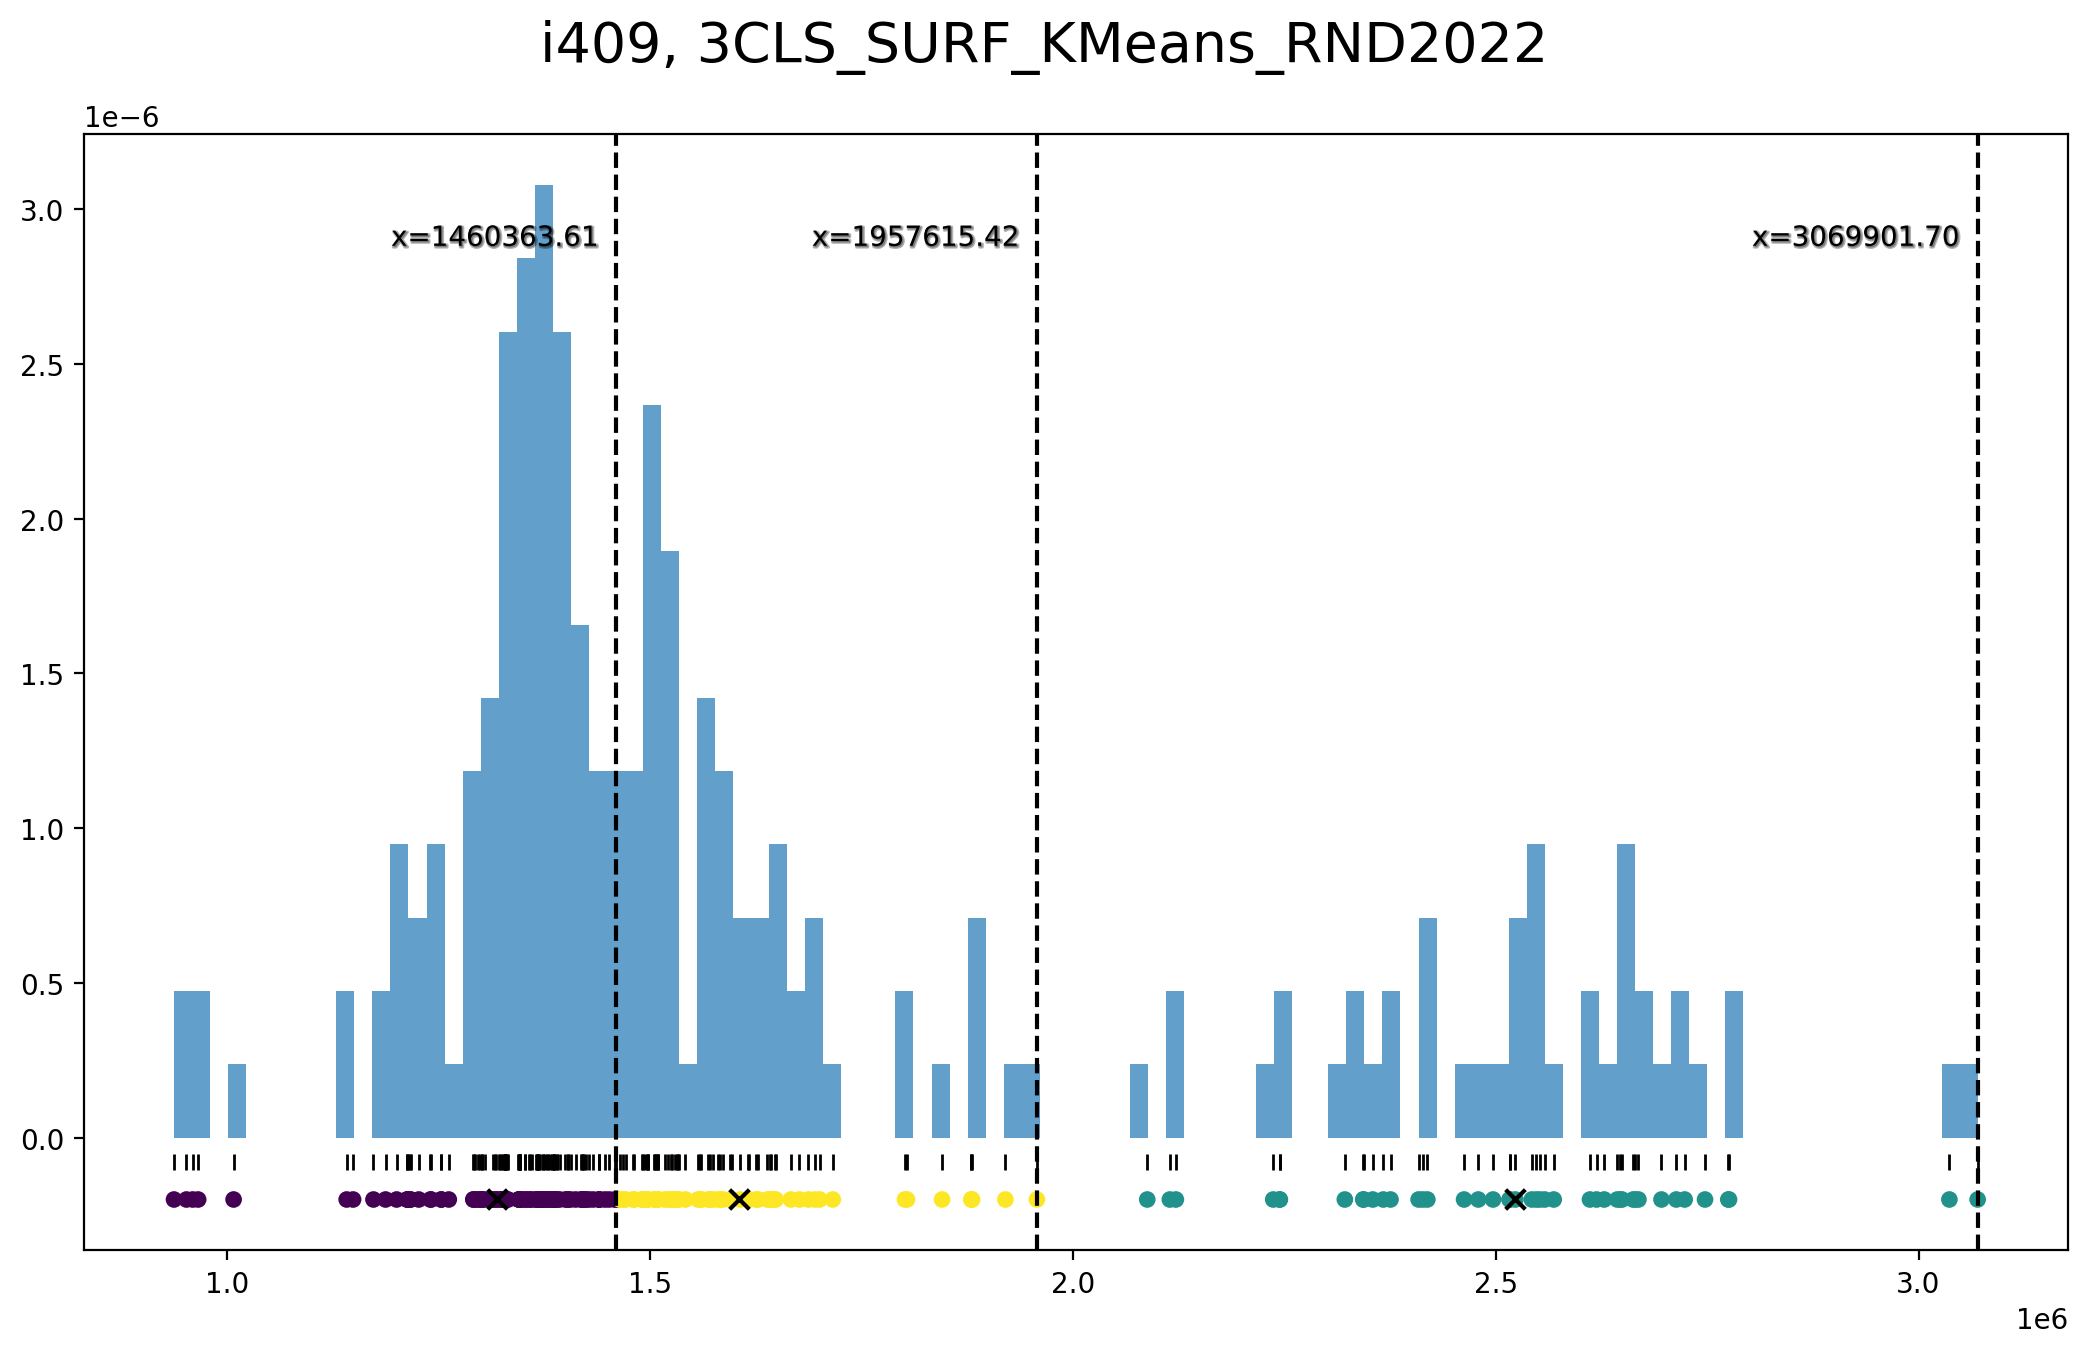

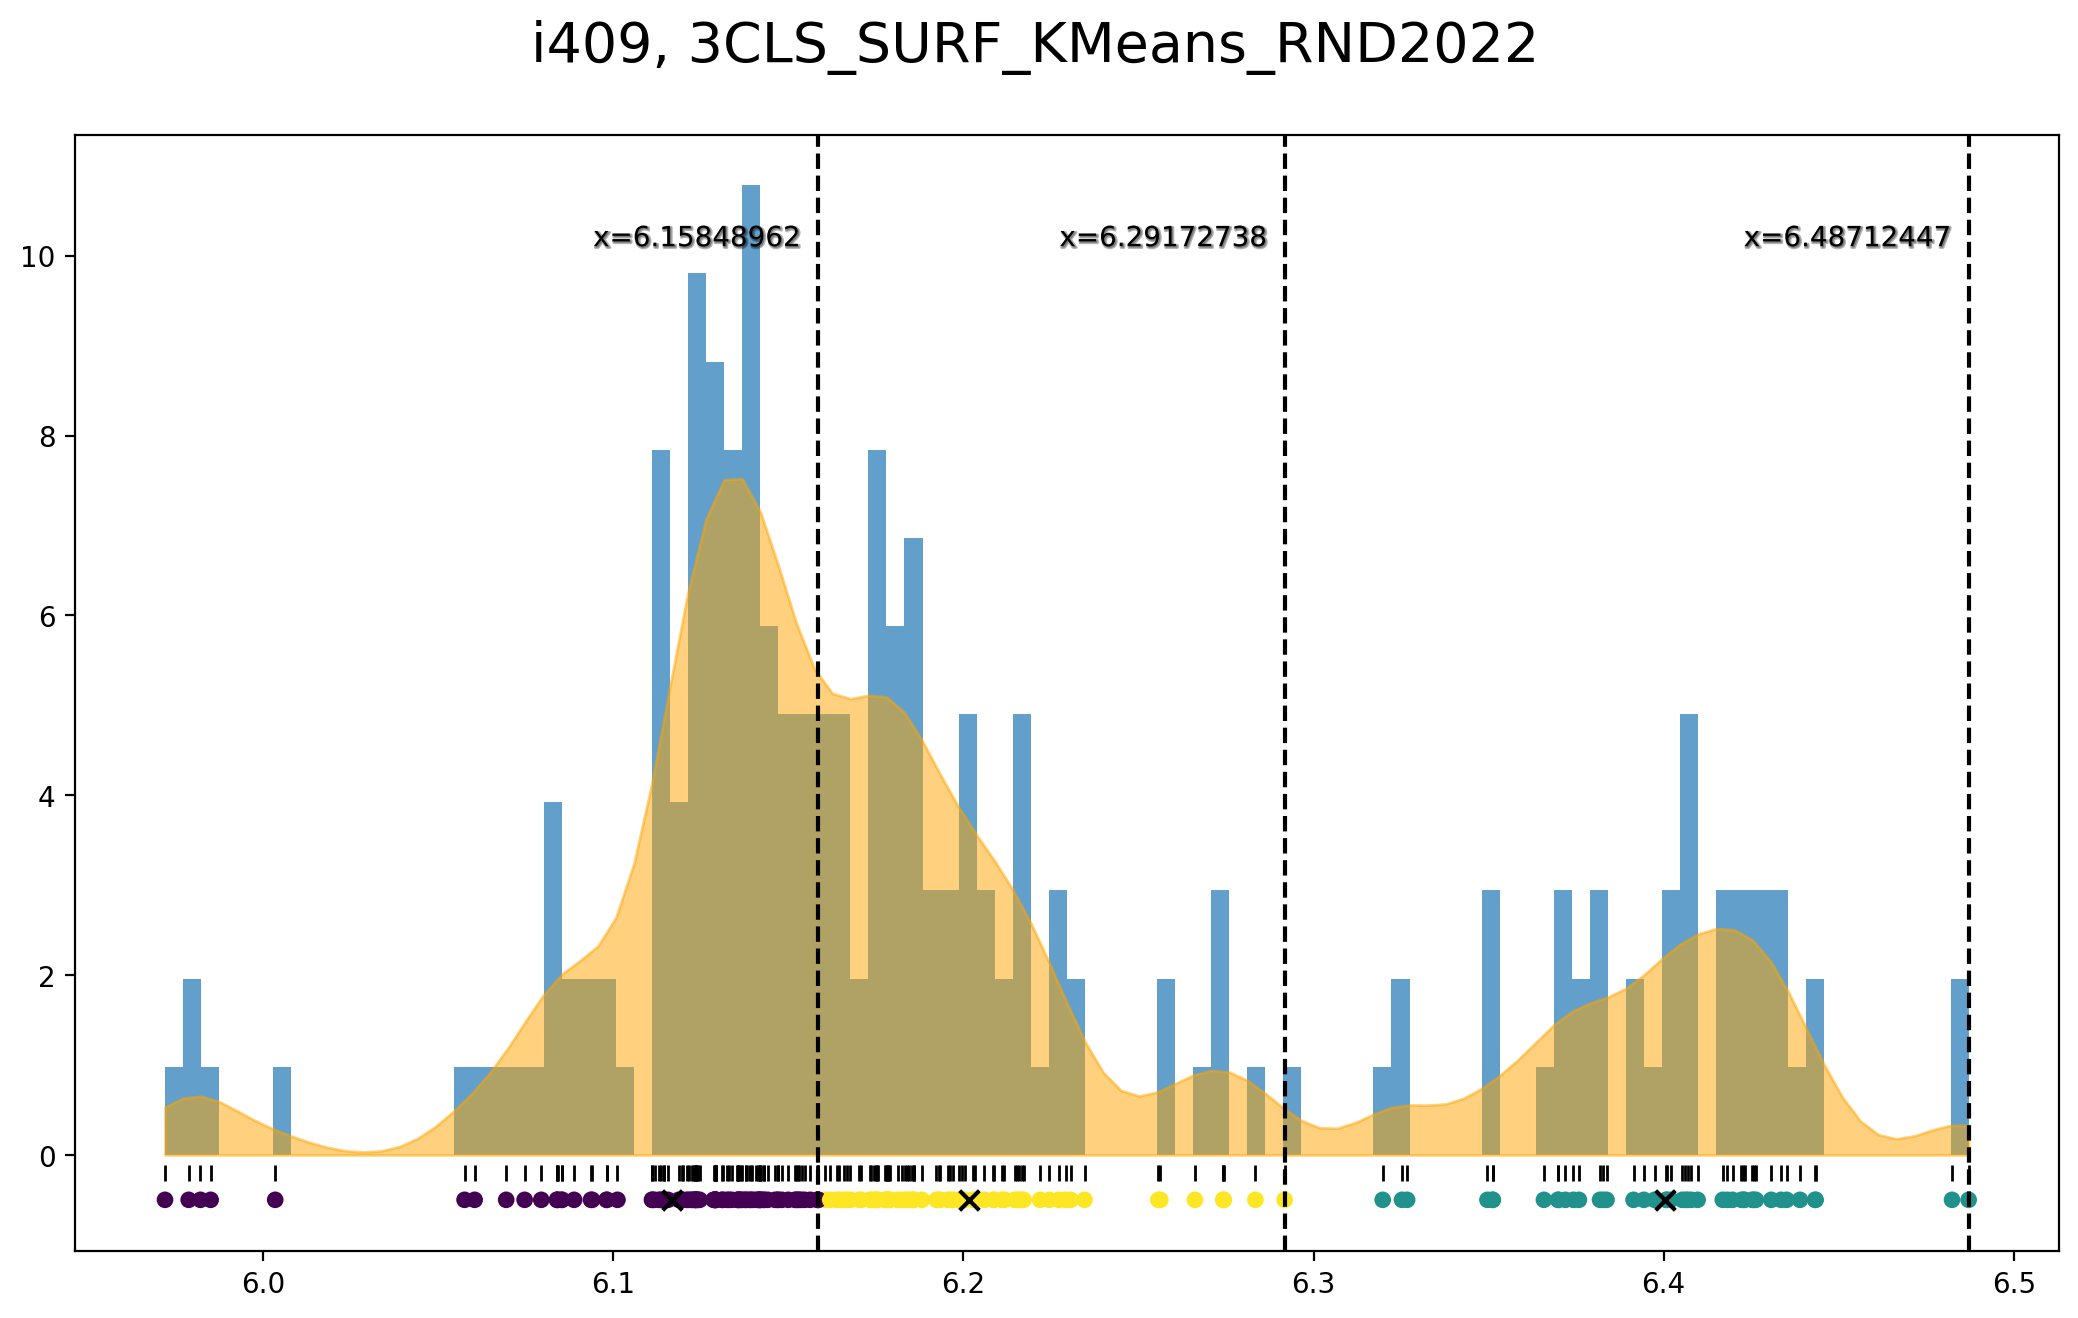

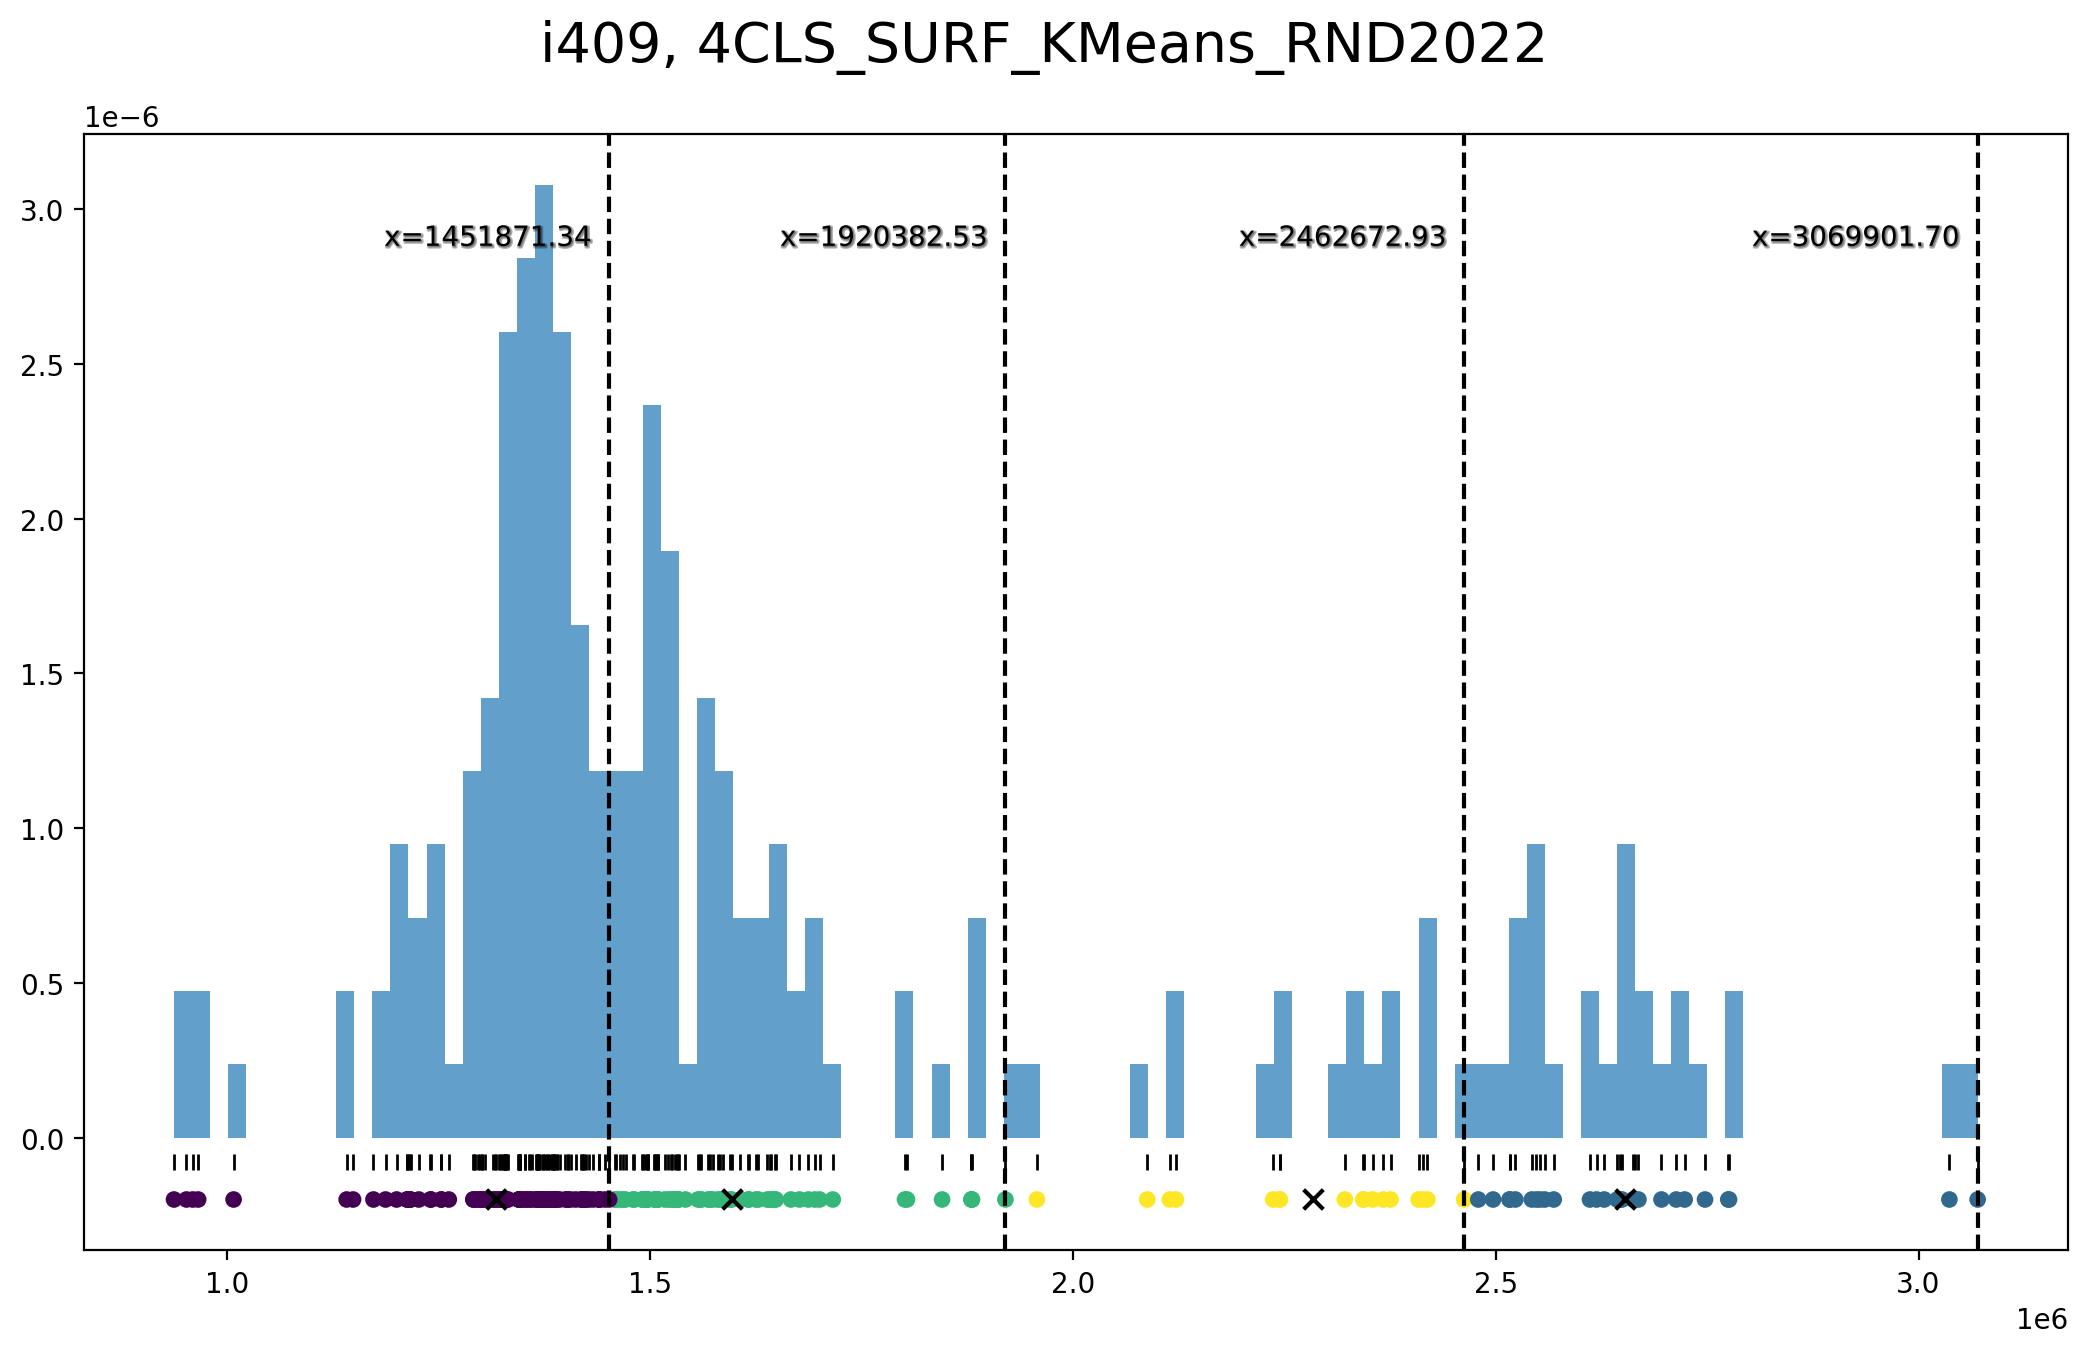

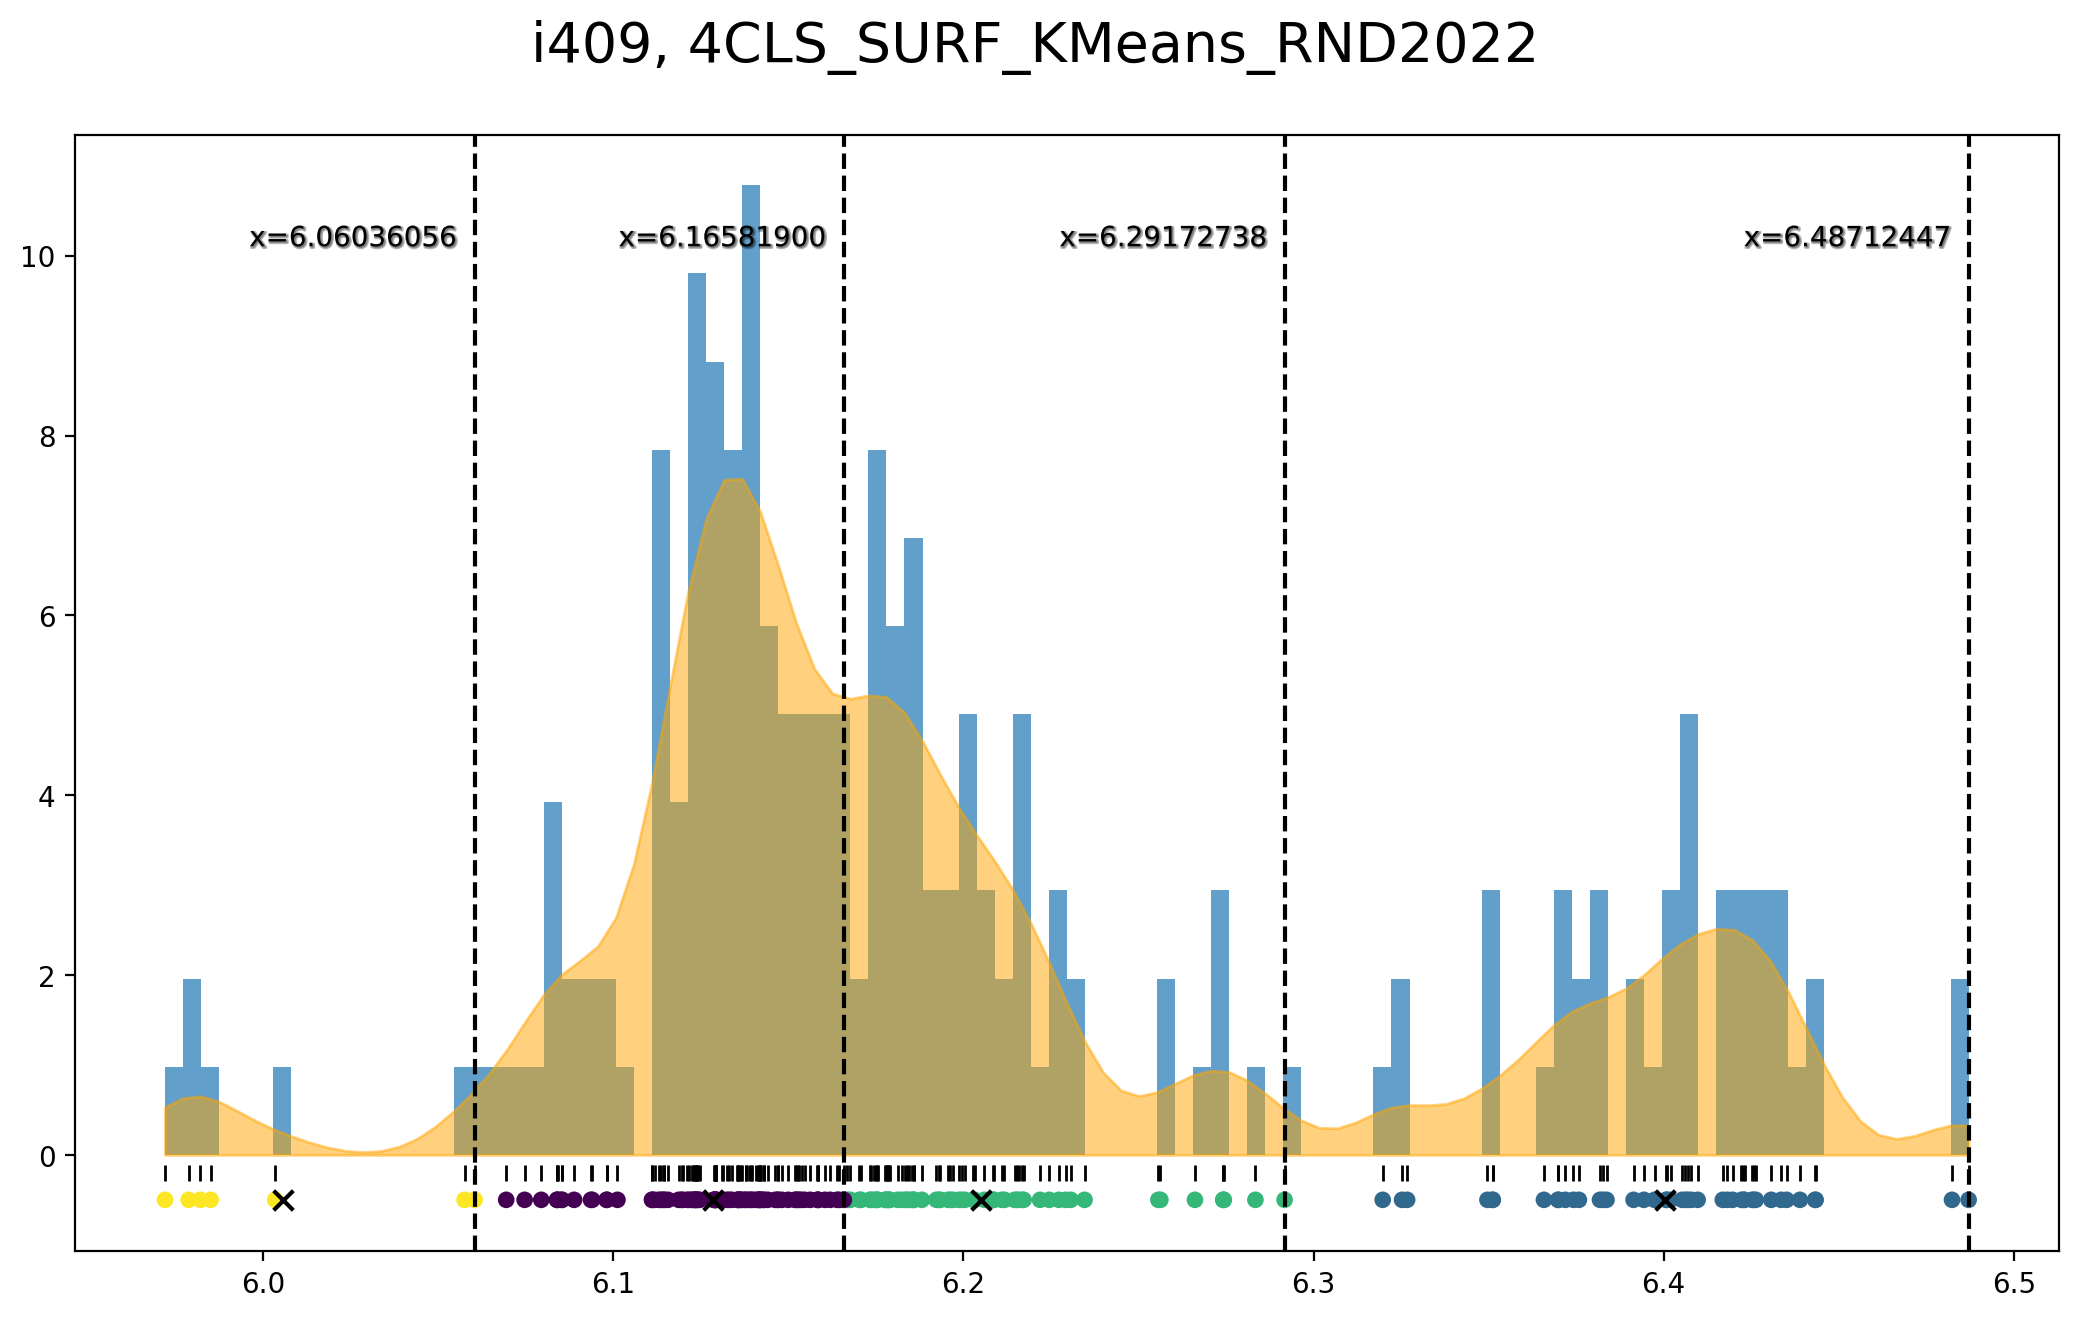

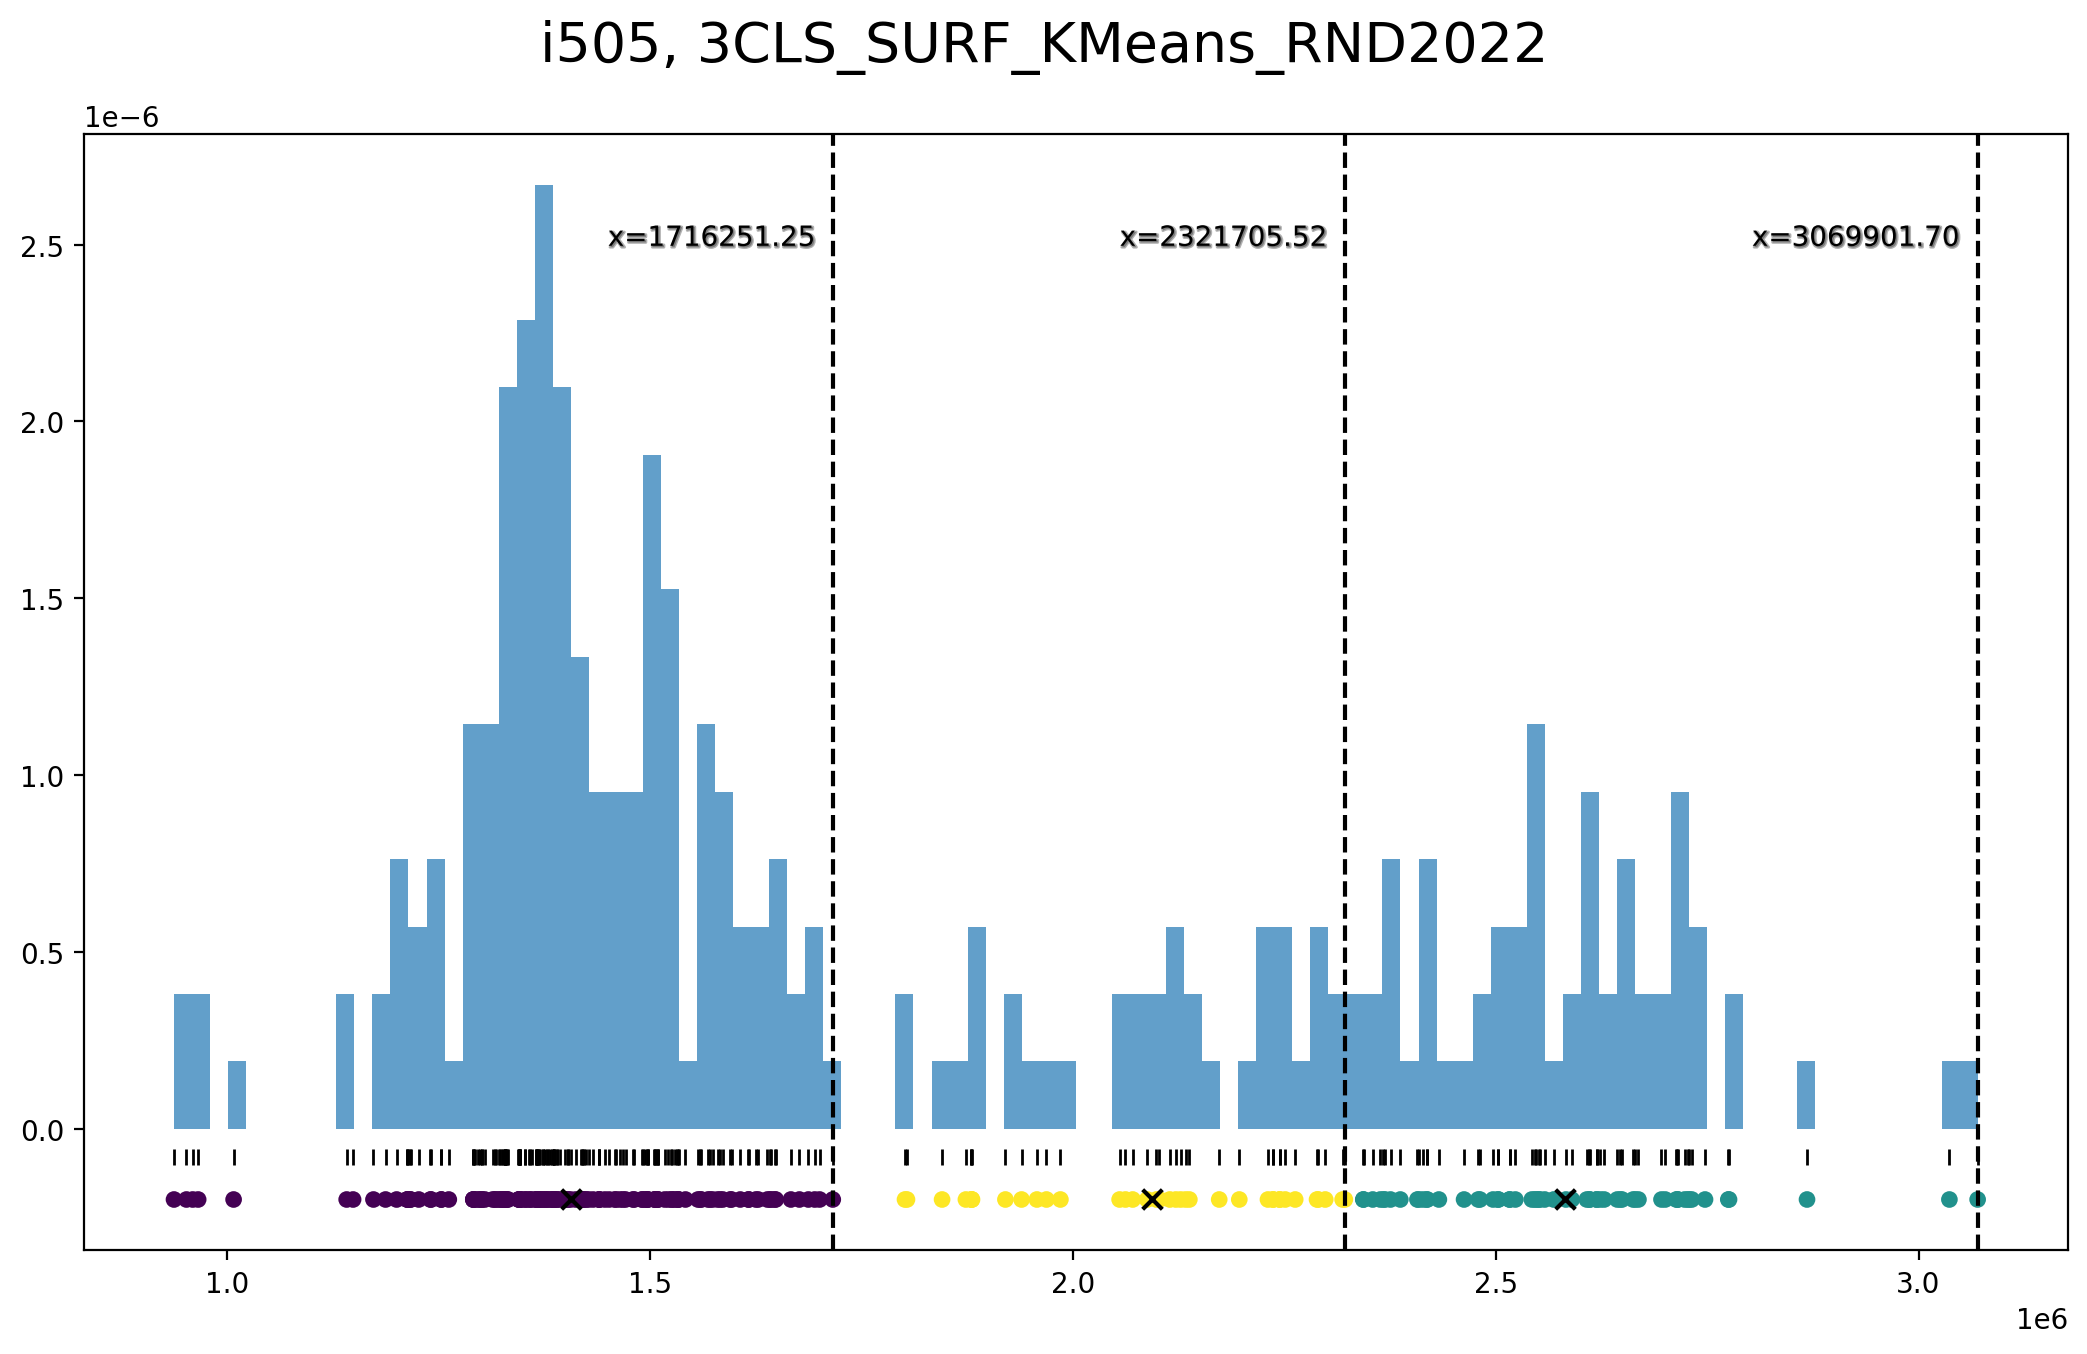

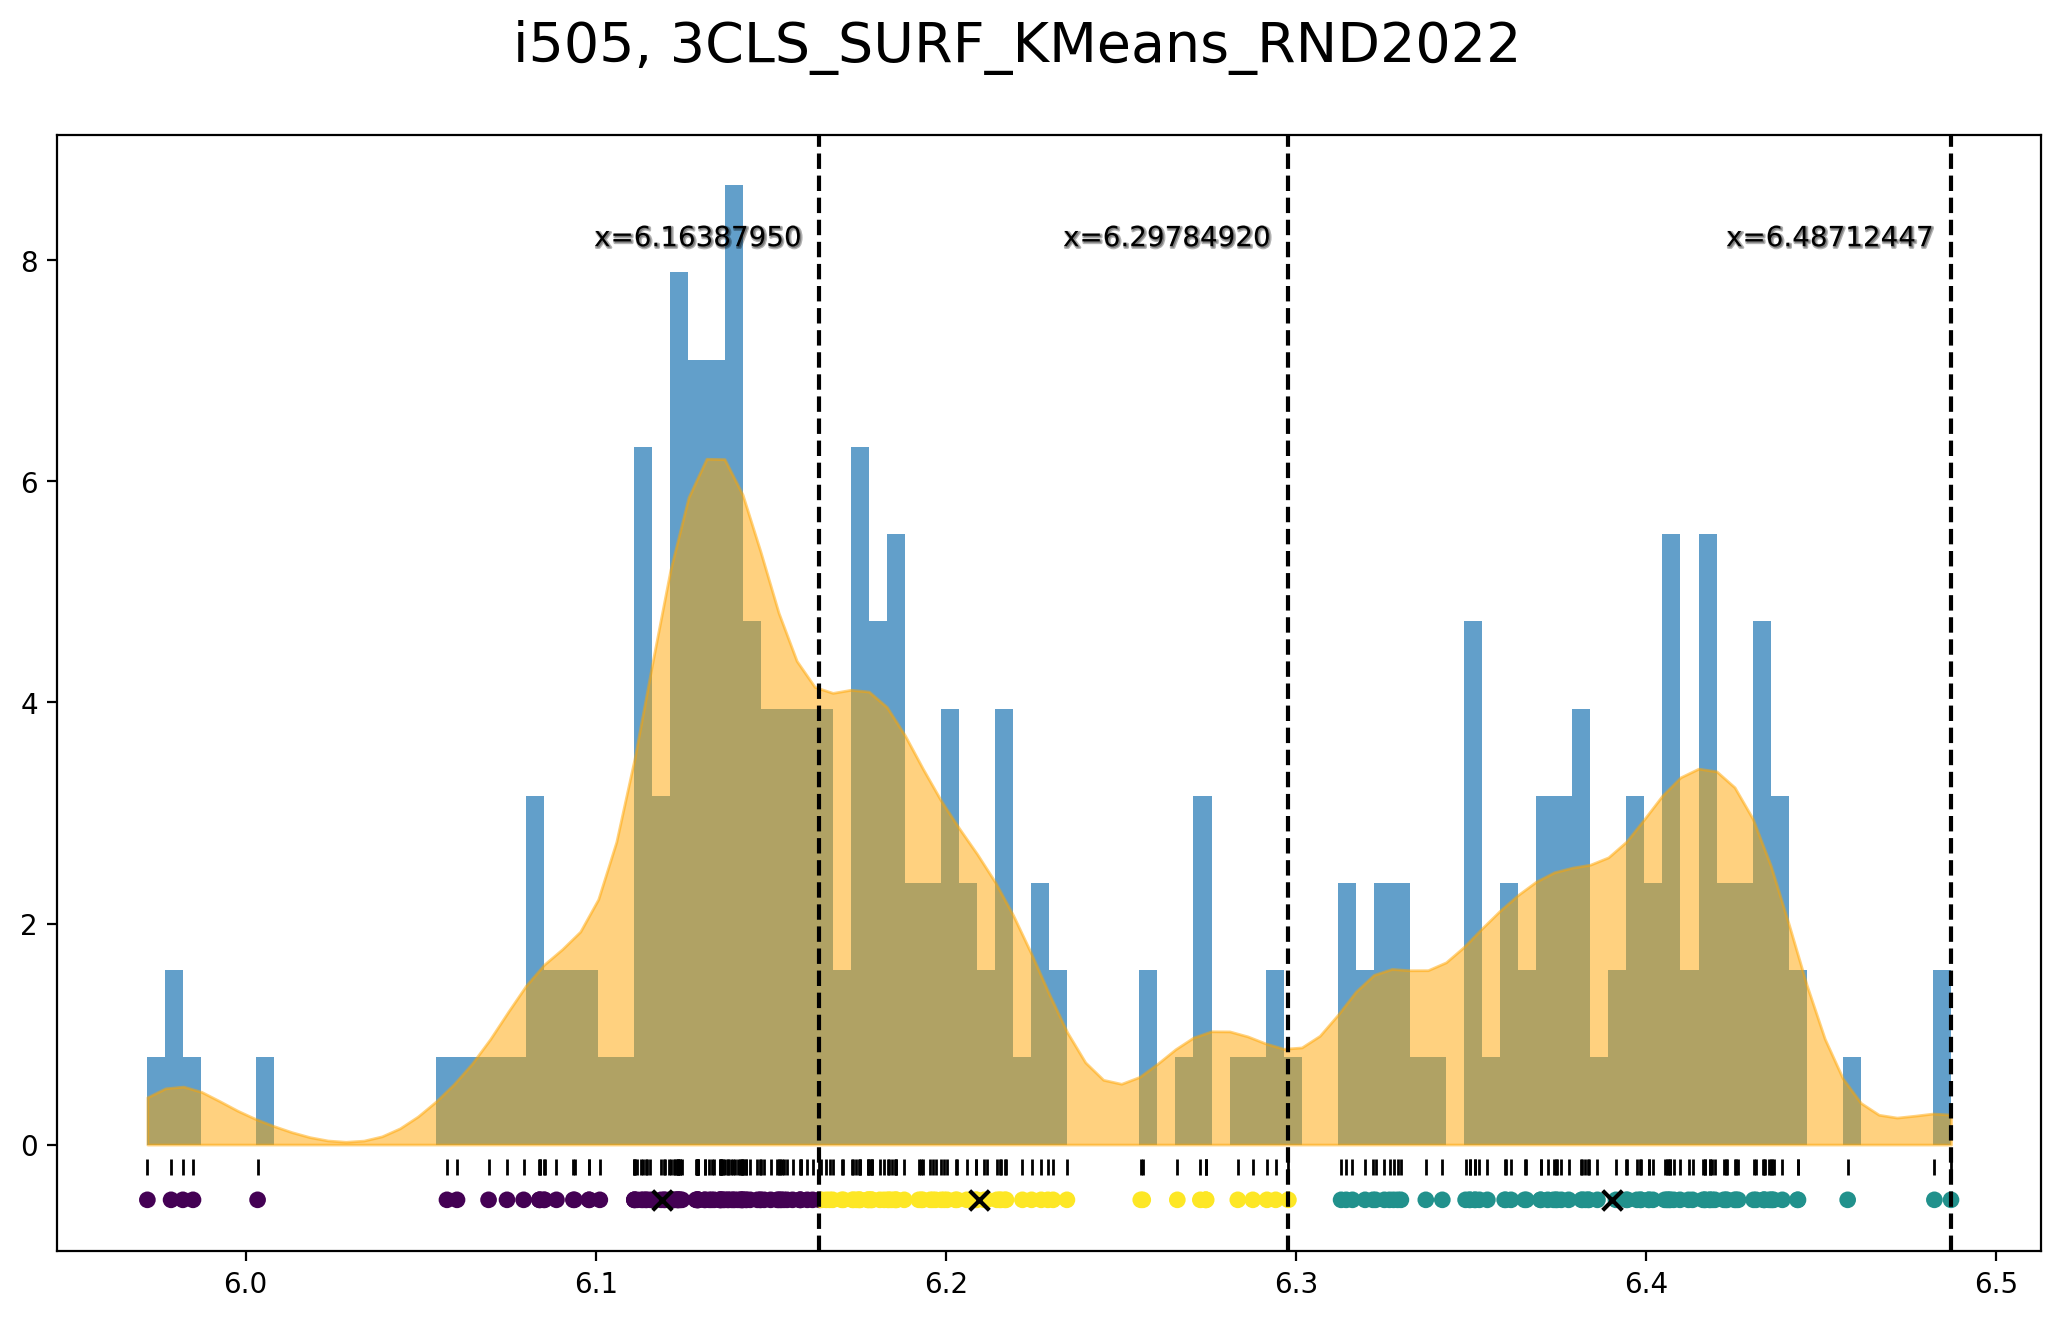

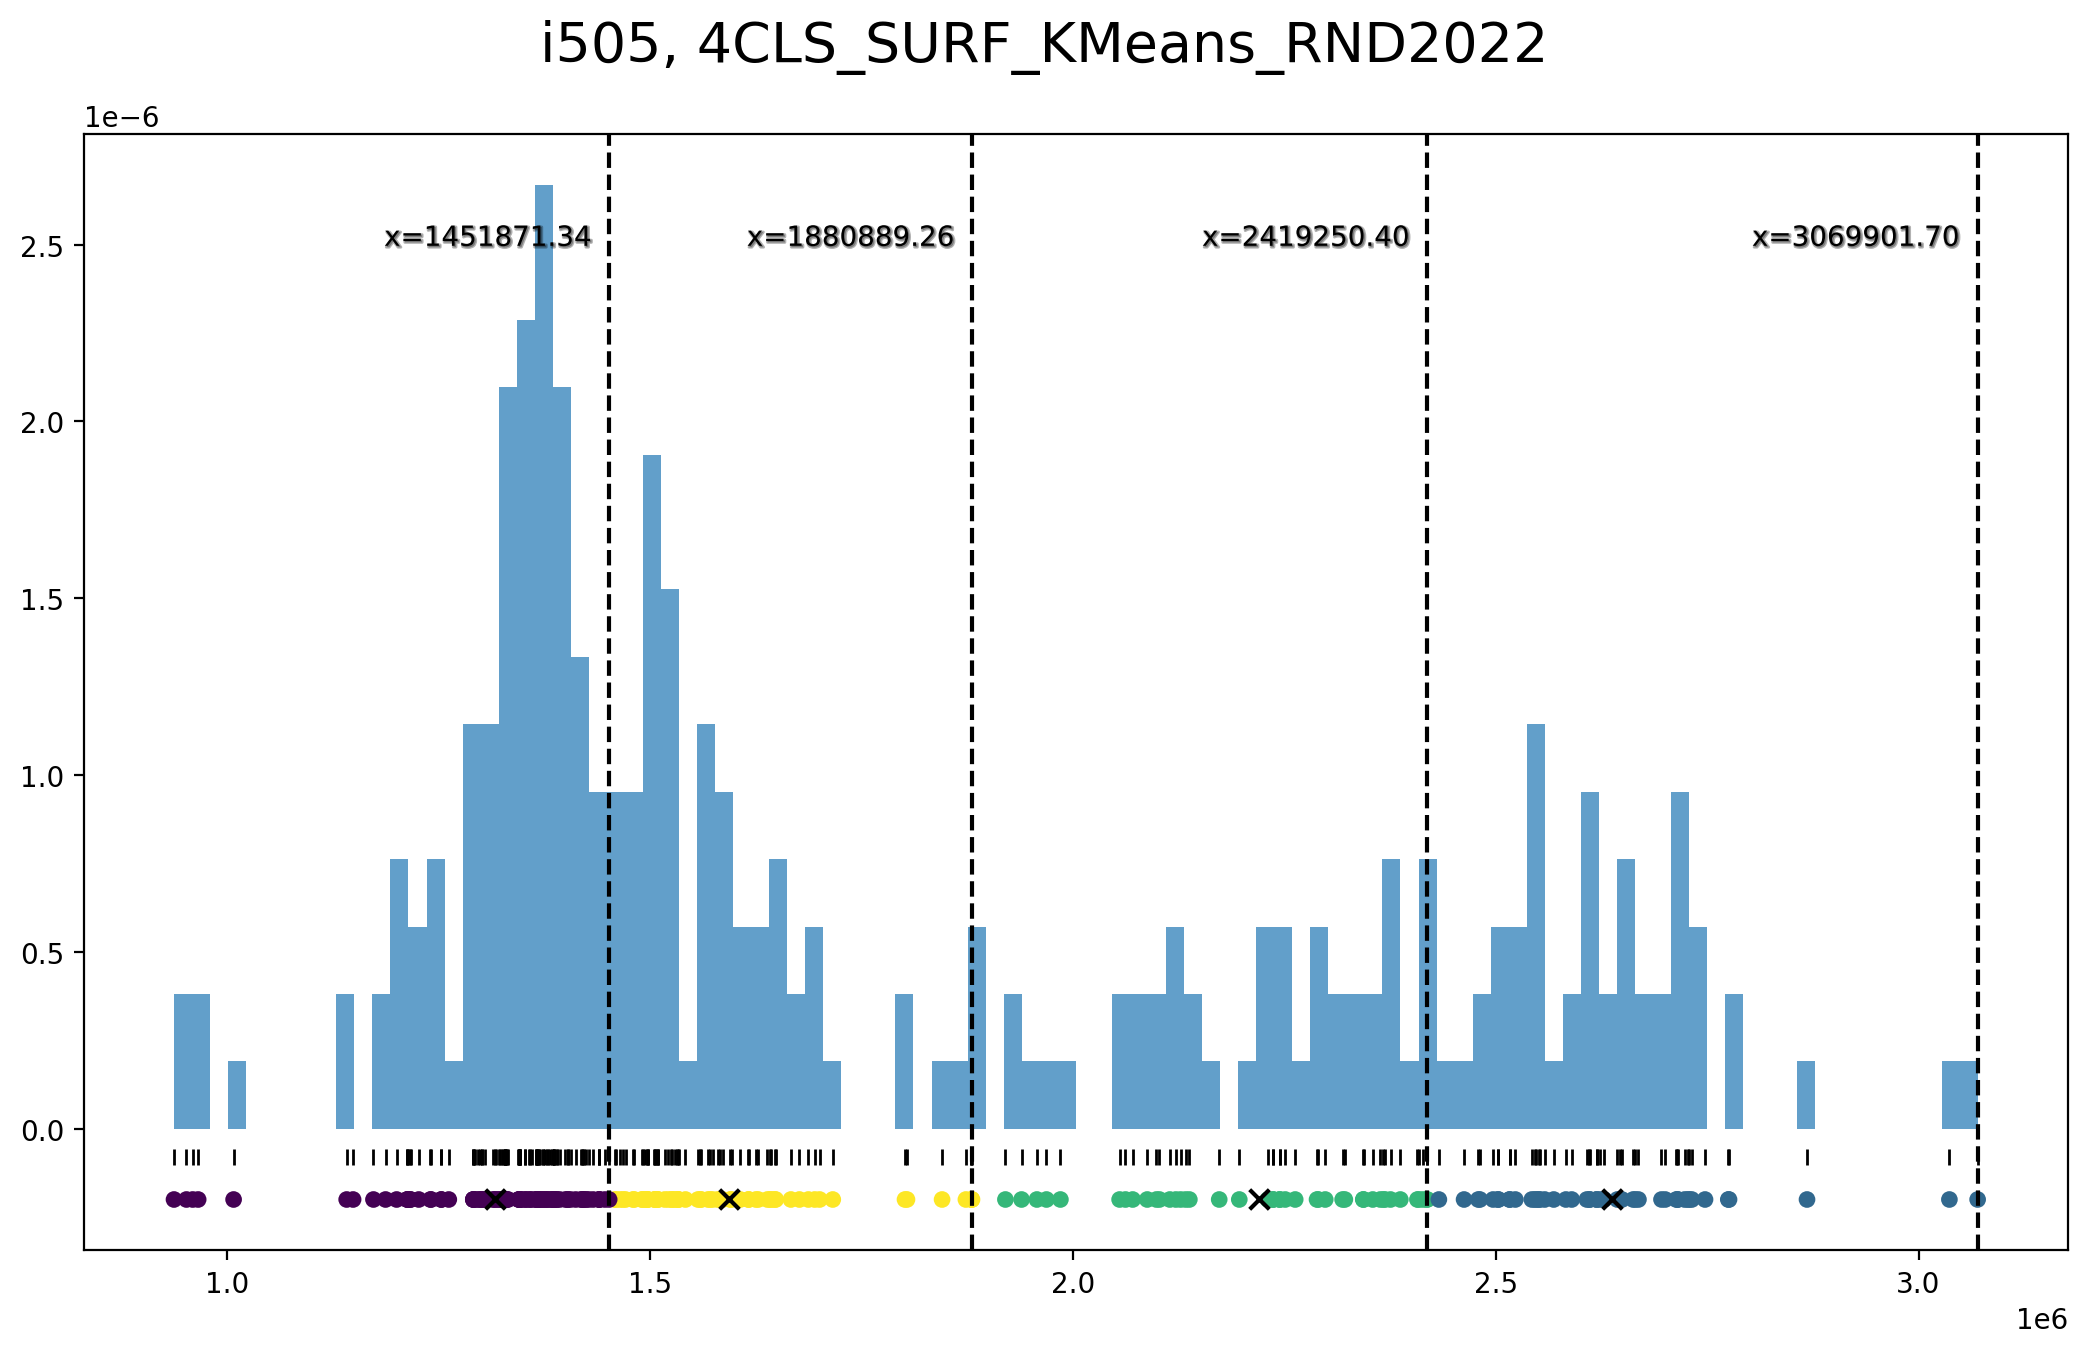

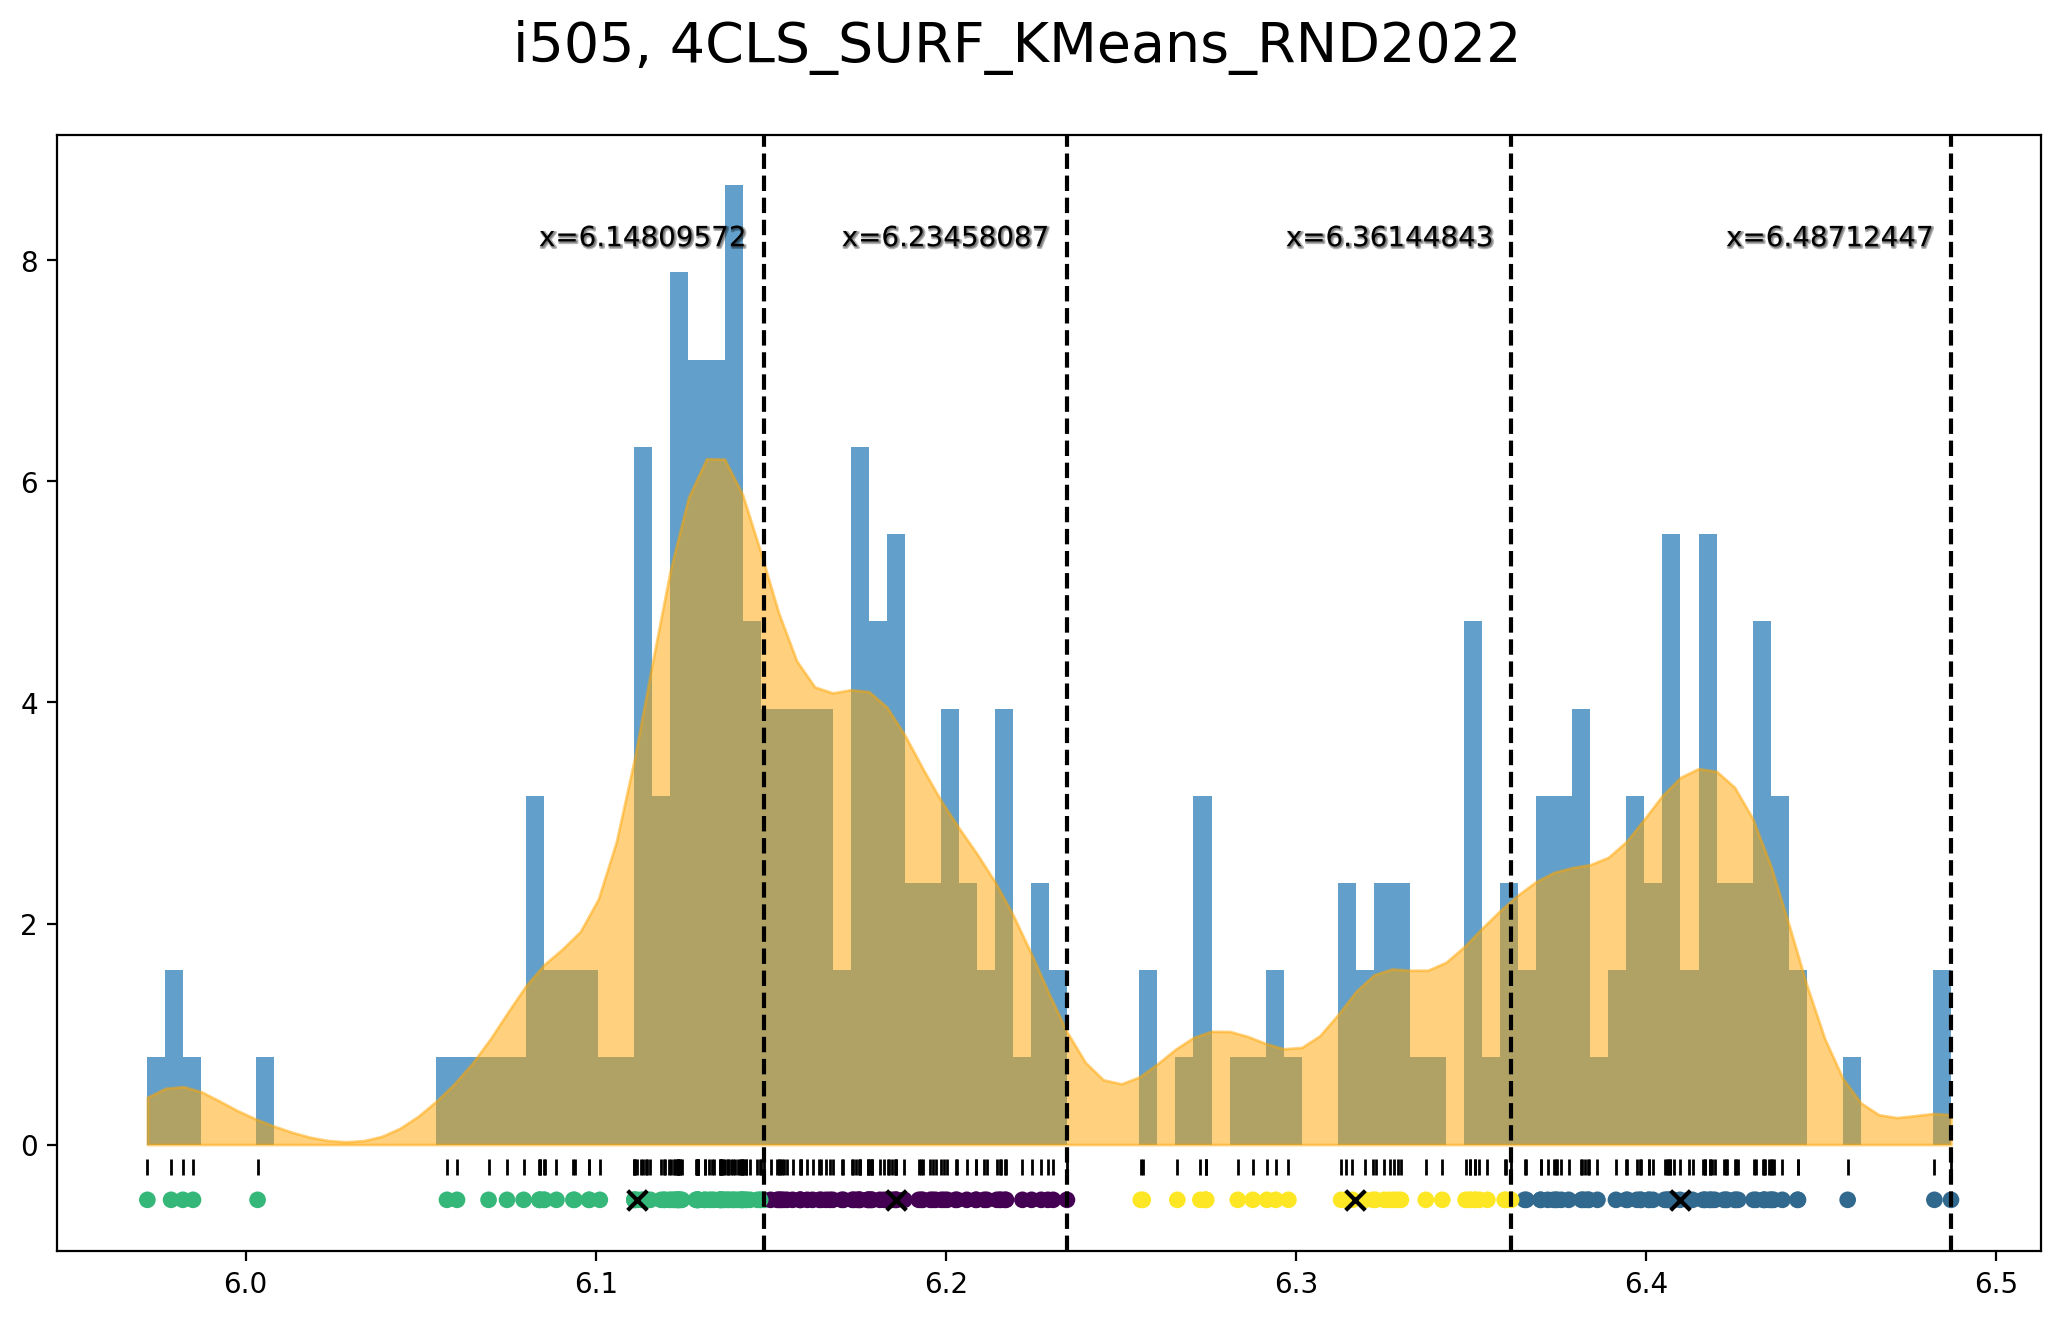

In [2]:
rand_seed = 2022

# -----------------------------------------------------------------------------------

pure_i409_xlsx_path = Path( r"C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\{Data}_Processed\{20230305_NEW_STRUCT}_Academia_Sinica_i409\data.xlsx" )
n_clusters = [3, 4]
label_str = [["S", "M", "L"], ["S", "M", "L", "XL"]]
for n, label in zip(n_clusters, label_str):
    SAKMeansCluster = SurfaceAreaKMeansCluster(pure_i409_xlsx_path, n, label,
                                               rand_seed, with_kde=False)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.plot_and_save_xlsx()
    
    SAKMeansCluster = SurfaceAreaKMeansCluster(pure_i409_xlsx_path, n, label,
                                               rand_seed, with_kde=True)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.plot_and_save_xlsx()


# -----------------------------------------------------------------------------------

pure_i505_xlsx_path = Path( r"C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\{Data}_Processed\{20230424_Update}_Academia_Sinica_i505\data.xlsx" )
n_clusters = [3, 4]
label_str = [["S", "M", "L"], ["S", "M", "L", "XL"]]
for n, label in zip(n_clusters, label_str):
    SAKMeansCluster = SurfaceAreaKMeansCluster(pure_i505_xlsx_path, n, label,
                                               rand_seed, with_kde=False)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.plot_and_save_xlsx()
    
    SAKMeansCluster = SurfaceAreaKMeansCluster(pure_i505_xlsx_path, n, label,
                                               rand_seed, with_kde=True)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.plot_and_save_xlsx()

 self.dataset_id  : i409
self.xlsx_path   : C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\!~OLD_FILE\xlsx\!~BeforeCluster (20230508)\{20230305_NEW_STRUCT}_Academia_Sinica_i409\{Modify}_xlsx\{3CLS_BY_SurfStDev}_data.xlsx
self.n_clusters  : 3
self.label_str   : ['S', 'M', 'L']
self.rand_seed   : 2022
self.with_kde    : False
self.sheet_name  : 0.5_STDEV

p = 1.0

kmeans_centers <class 'numpy.ndarray'>: 
[[1604975.43098361]
 [2523261.02023256]
 [1319823.19702128]]

self.clusters_max_area <class 'list'>: [1957615.42, 3069901.7, 1460363.61]

 self.dataset_id  : i409
self.xlsx_path   : C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\!~OLD_FILE\xlsx\!~BeforeCluster (20230508)\{20230305_NEW_STRUCT}_Academia_Sinica_i409\{Modify}_xlsx\{3CLS_BY_SurfStDev}_data.xlsx
self.n_clusters  : 3
self.label_str   : ['S', 'M', 'L']
self.rand_seed   : 2022
self.with_kde    : True
self.sheet_name  : 0.5_STDEV

p = 0.9999999999999999

kmeans_centers <class 'numpy.ndarray'>: 
[[6.1168

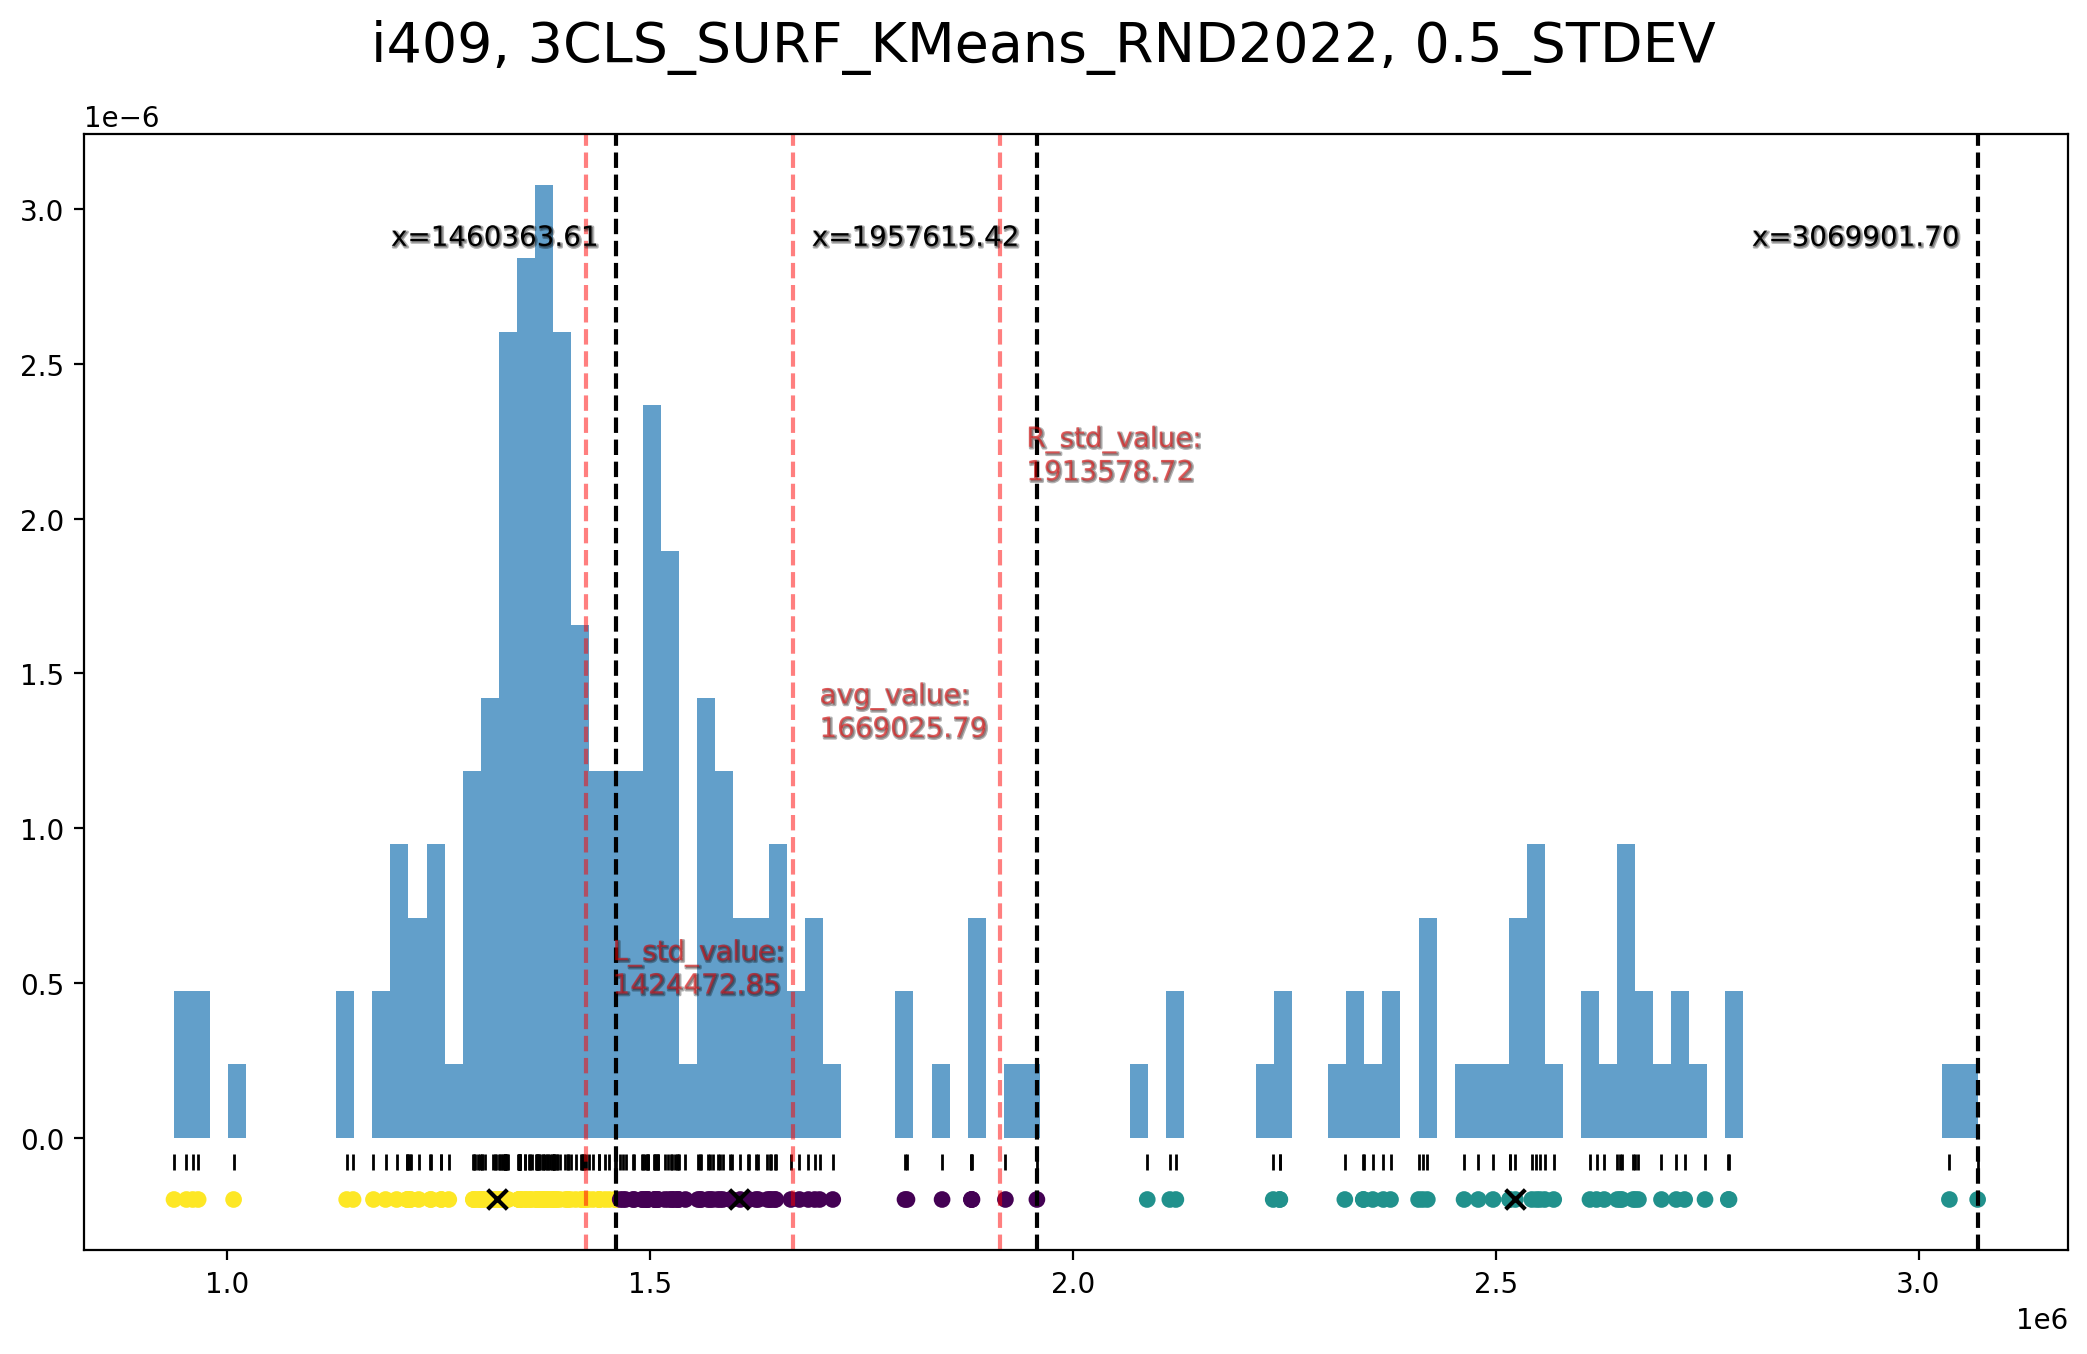

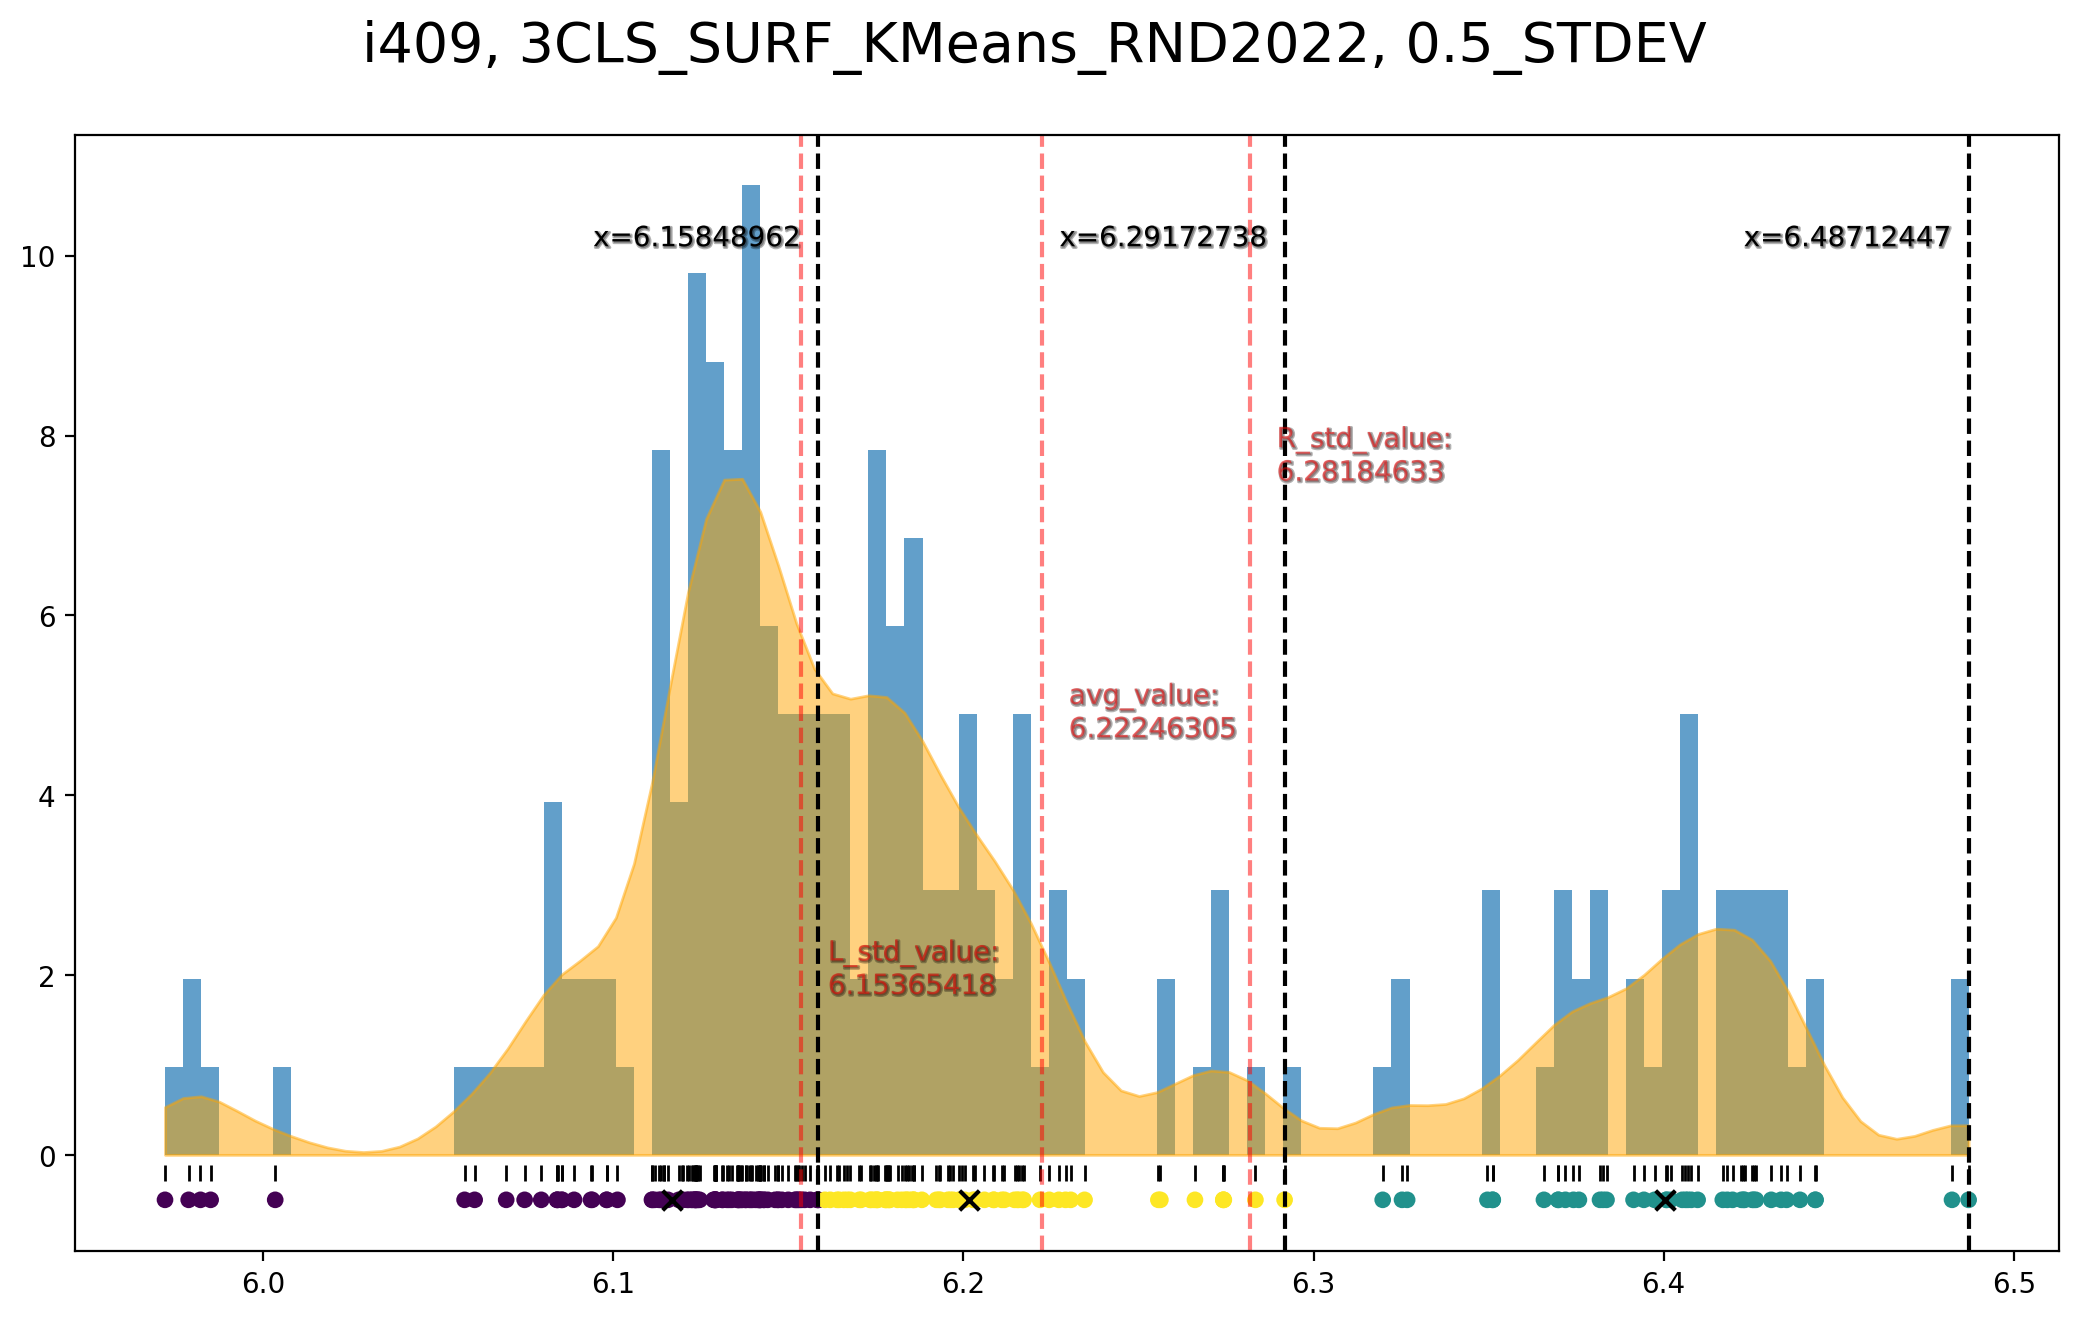

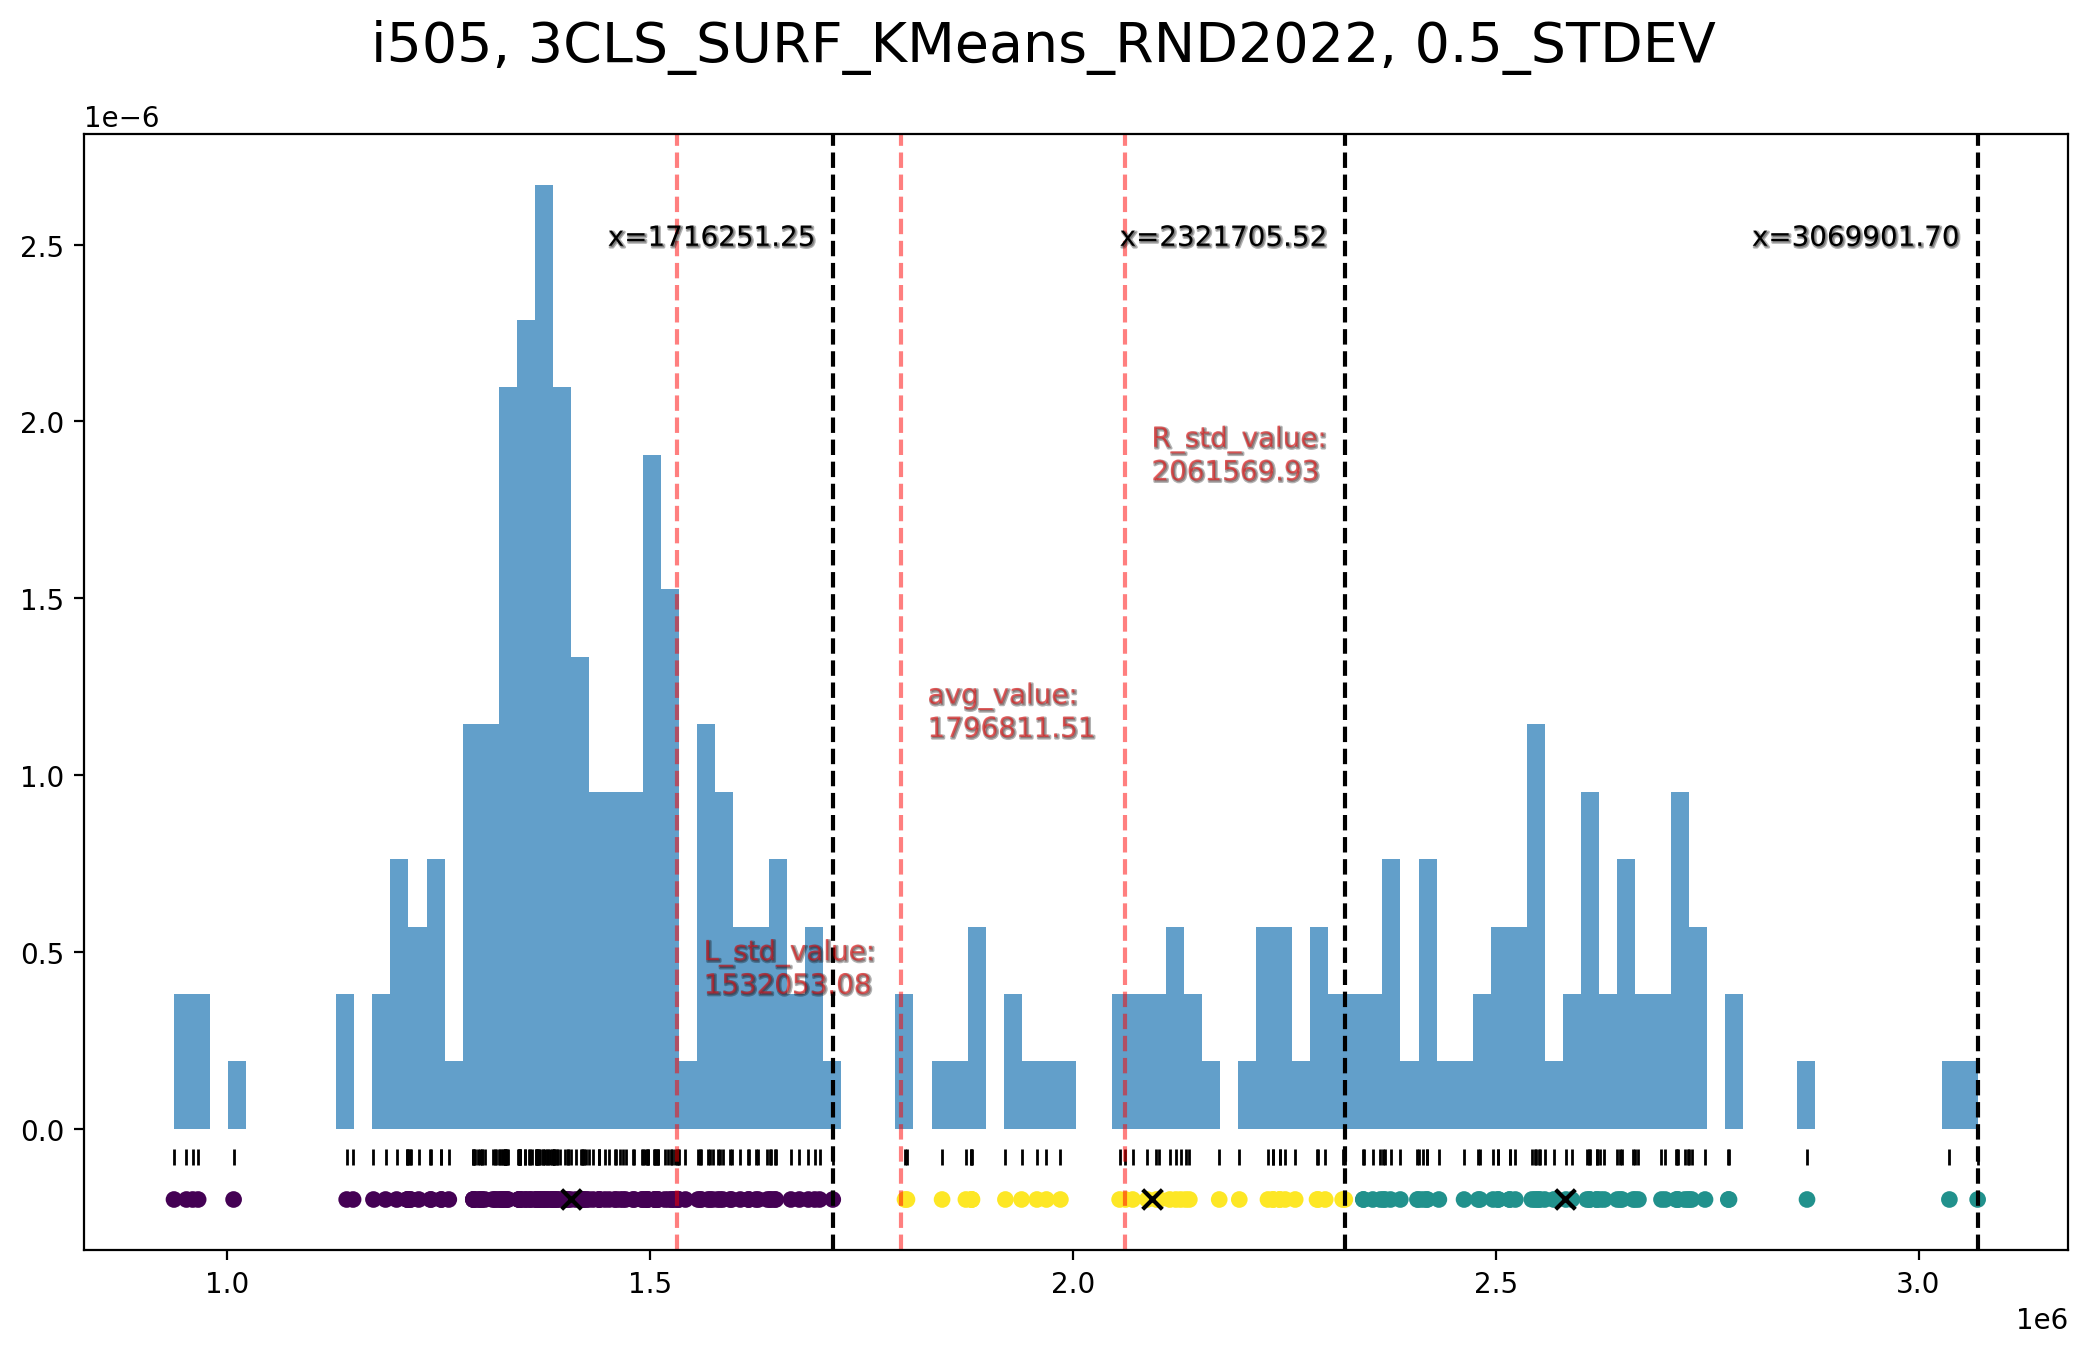

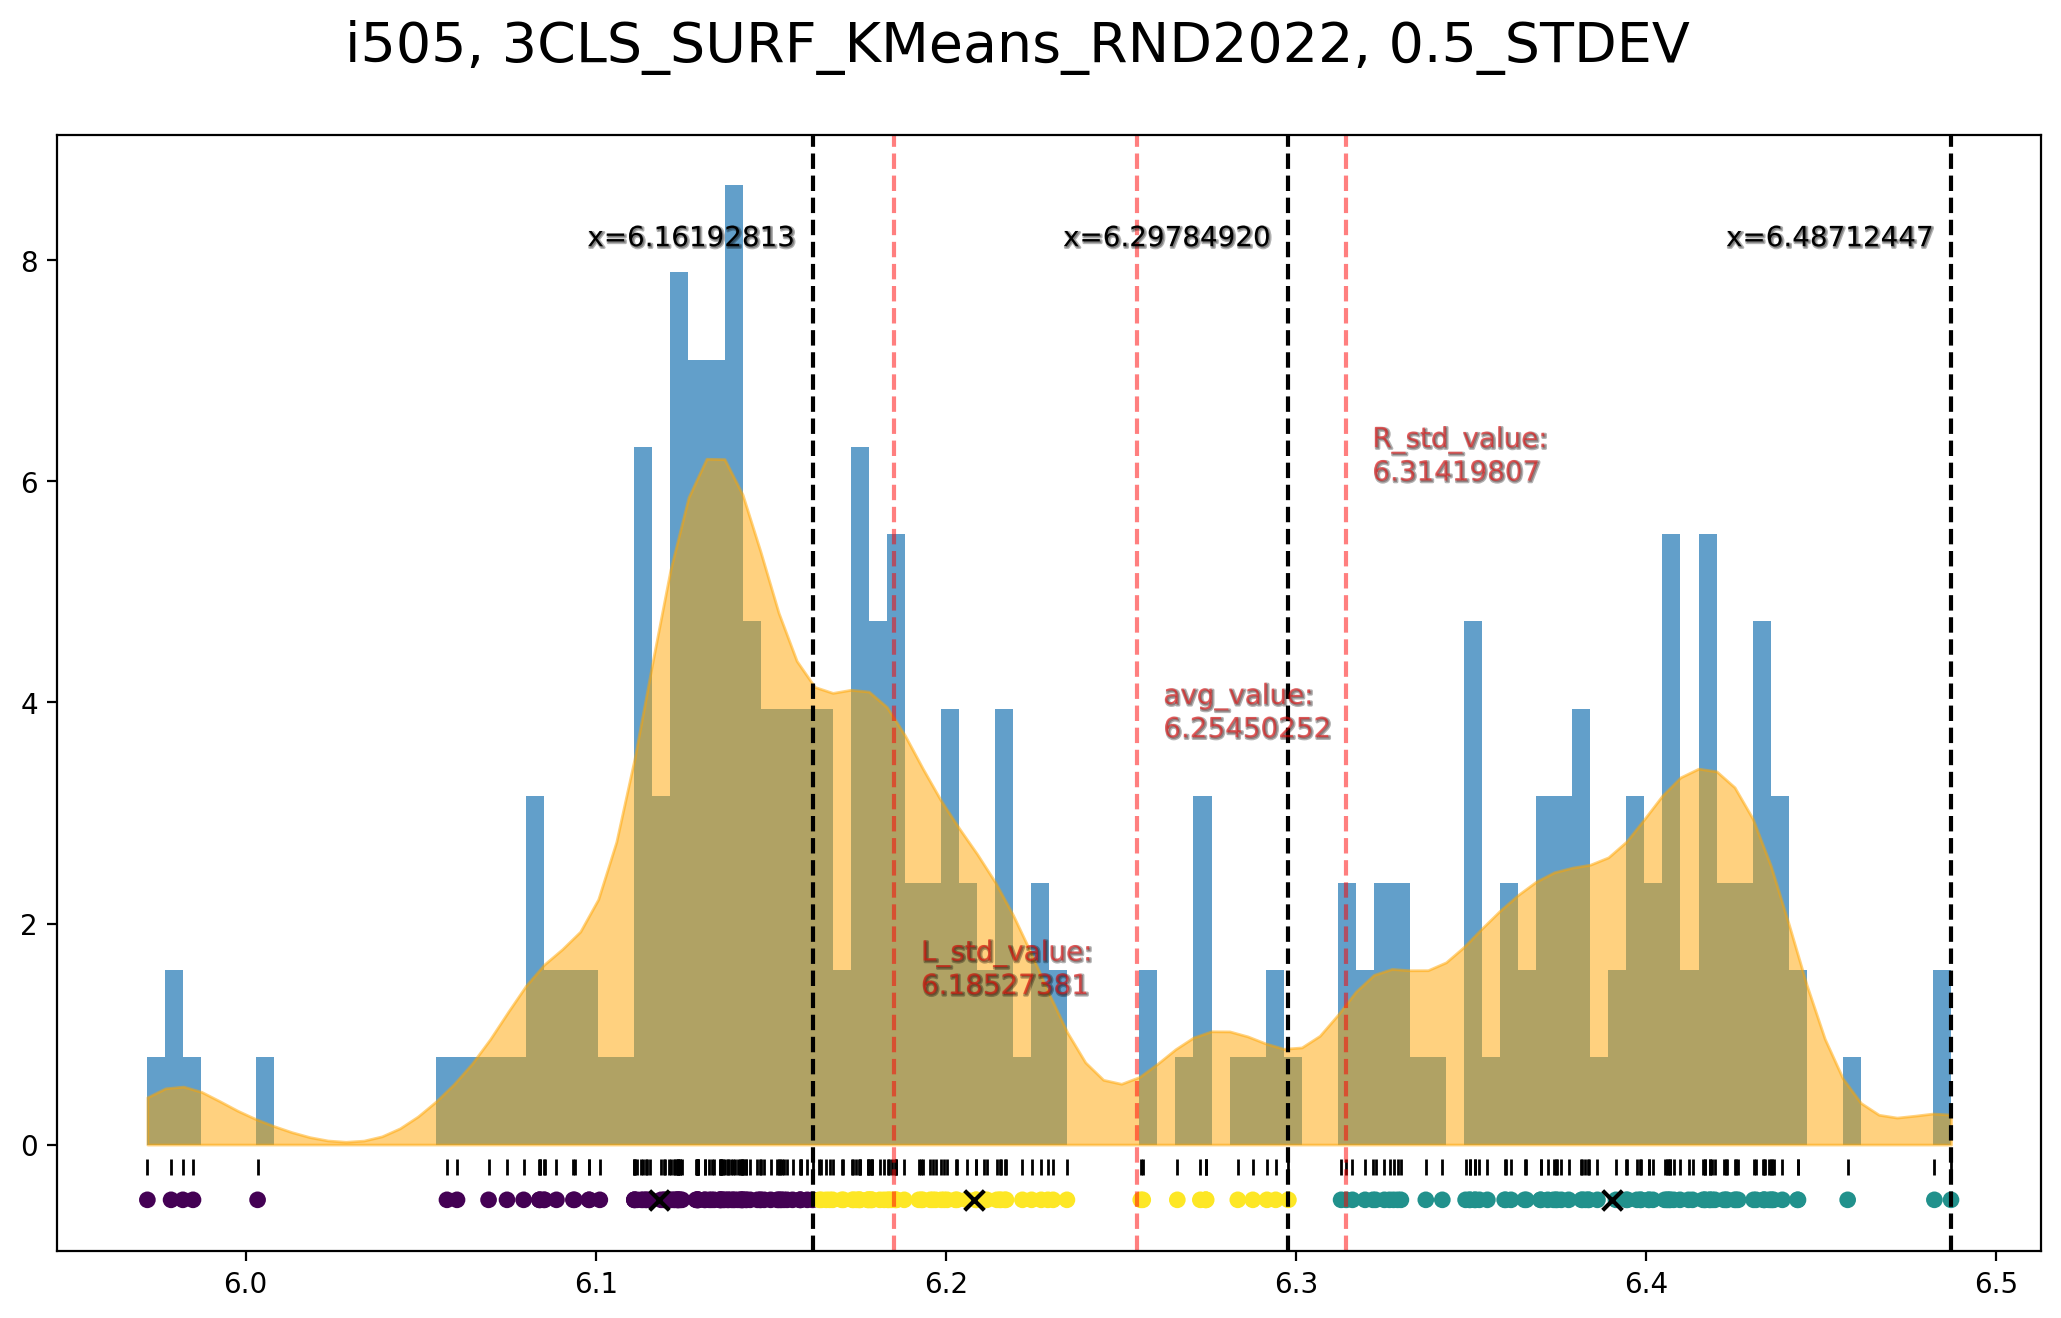

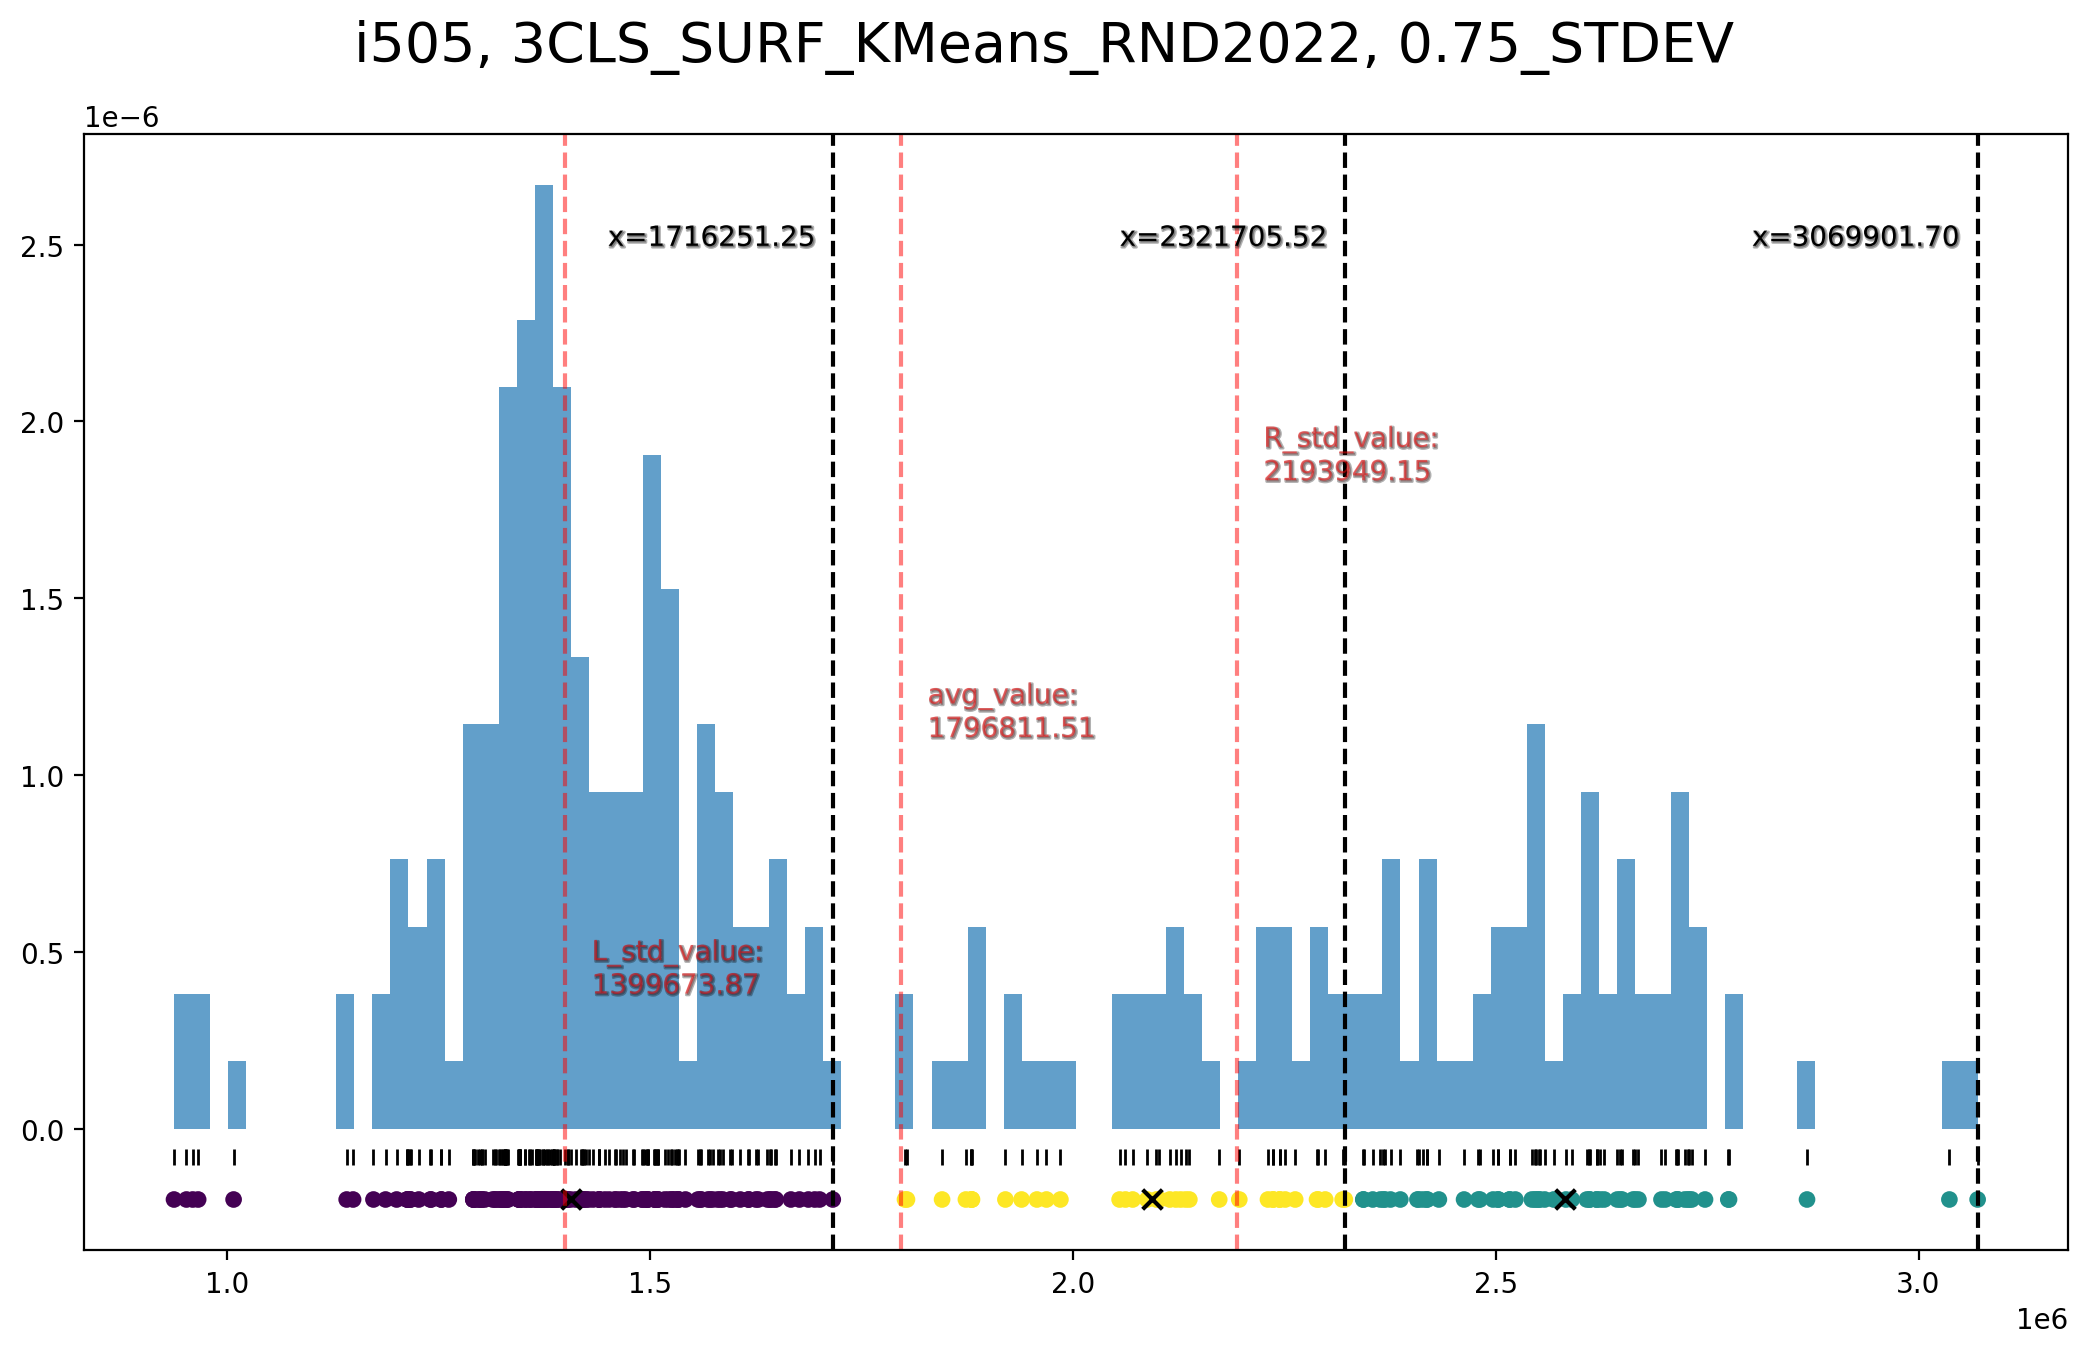

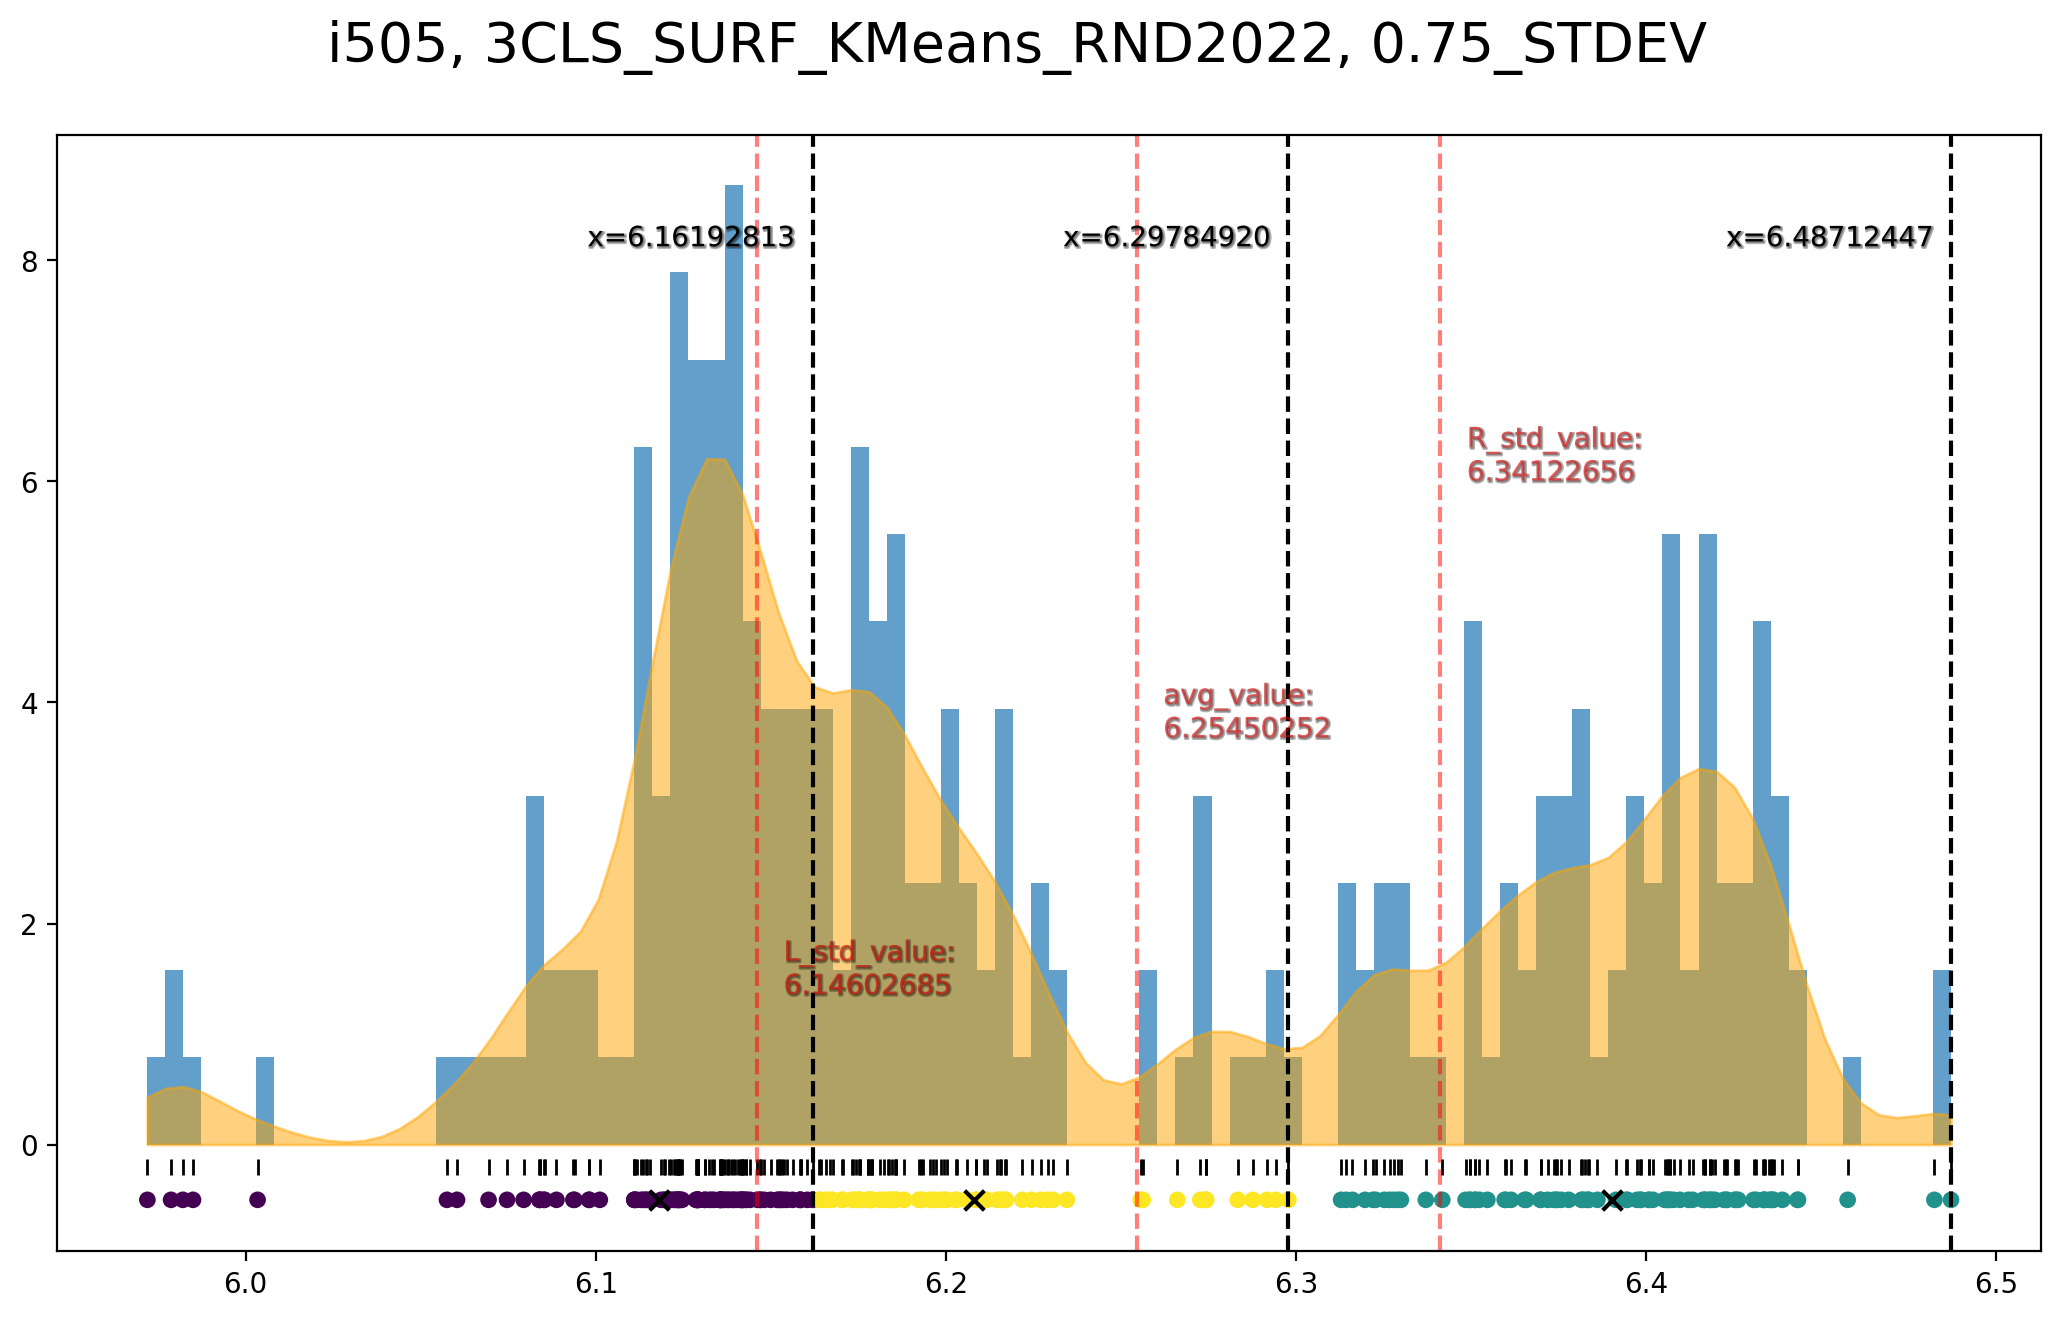

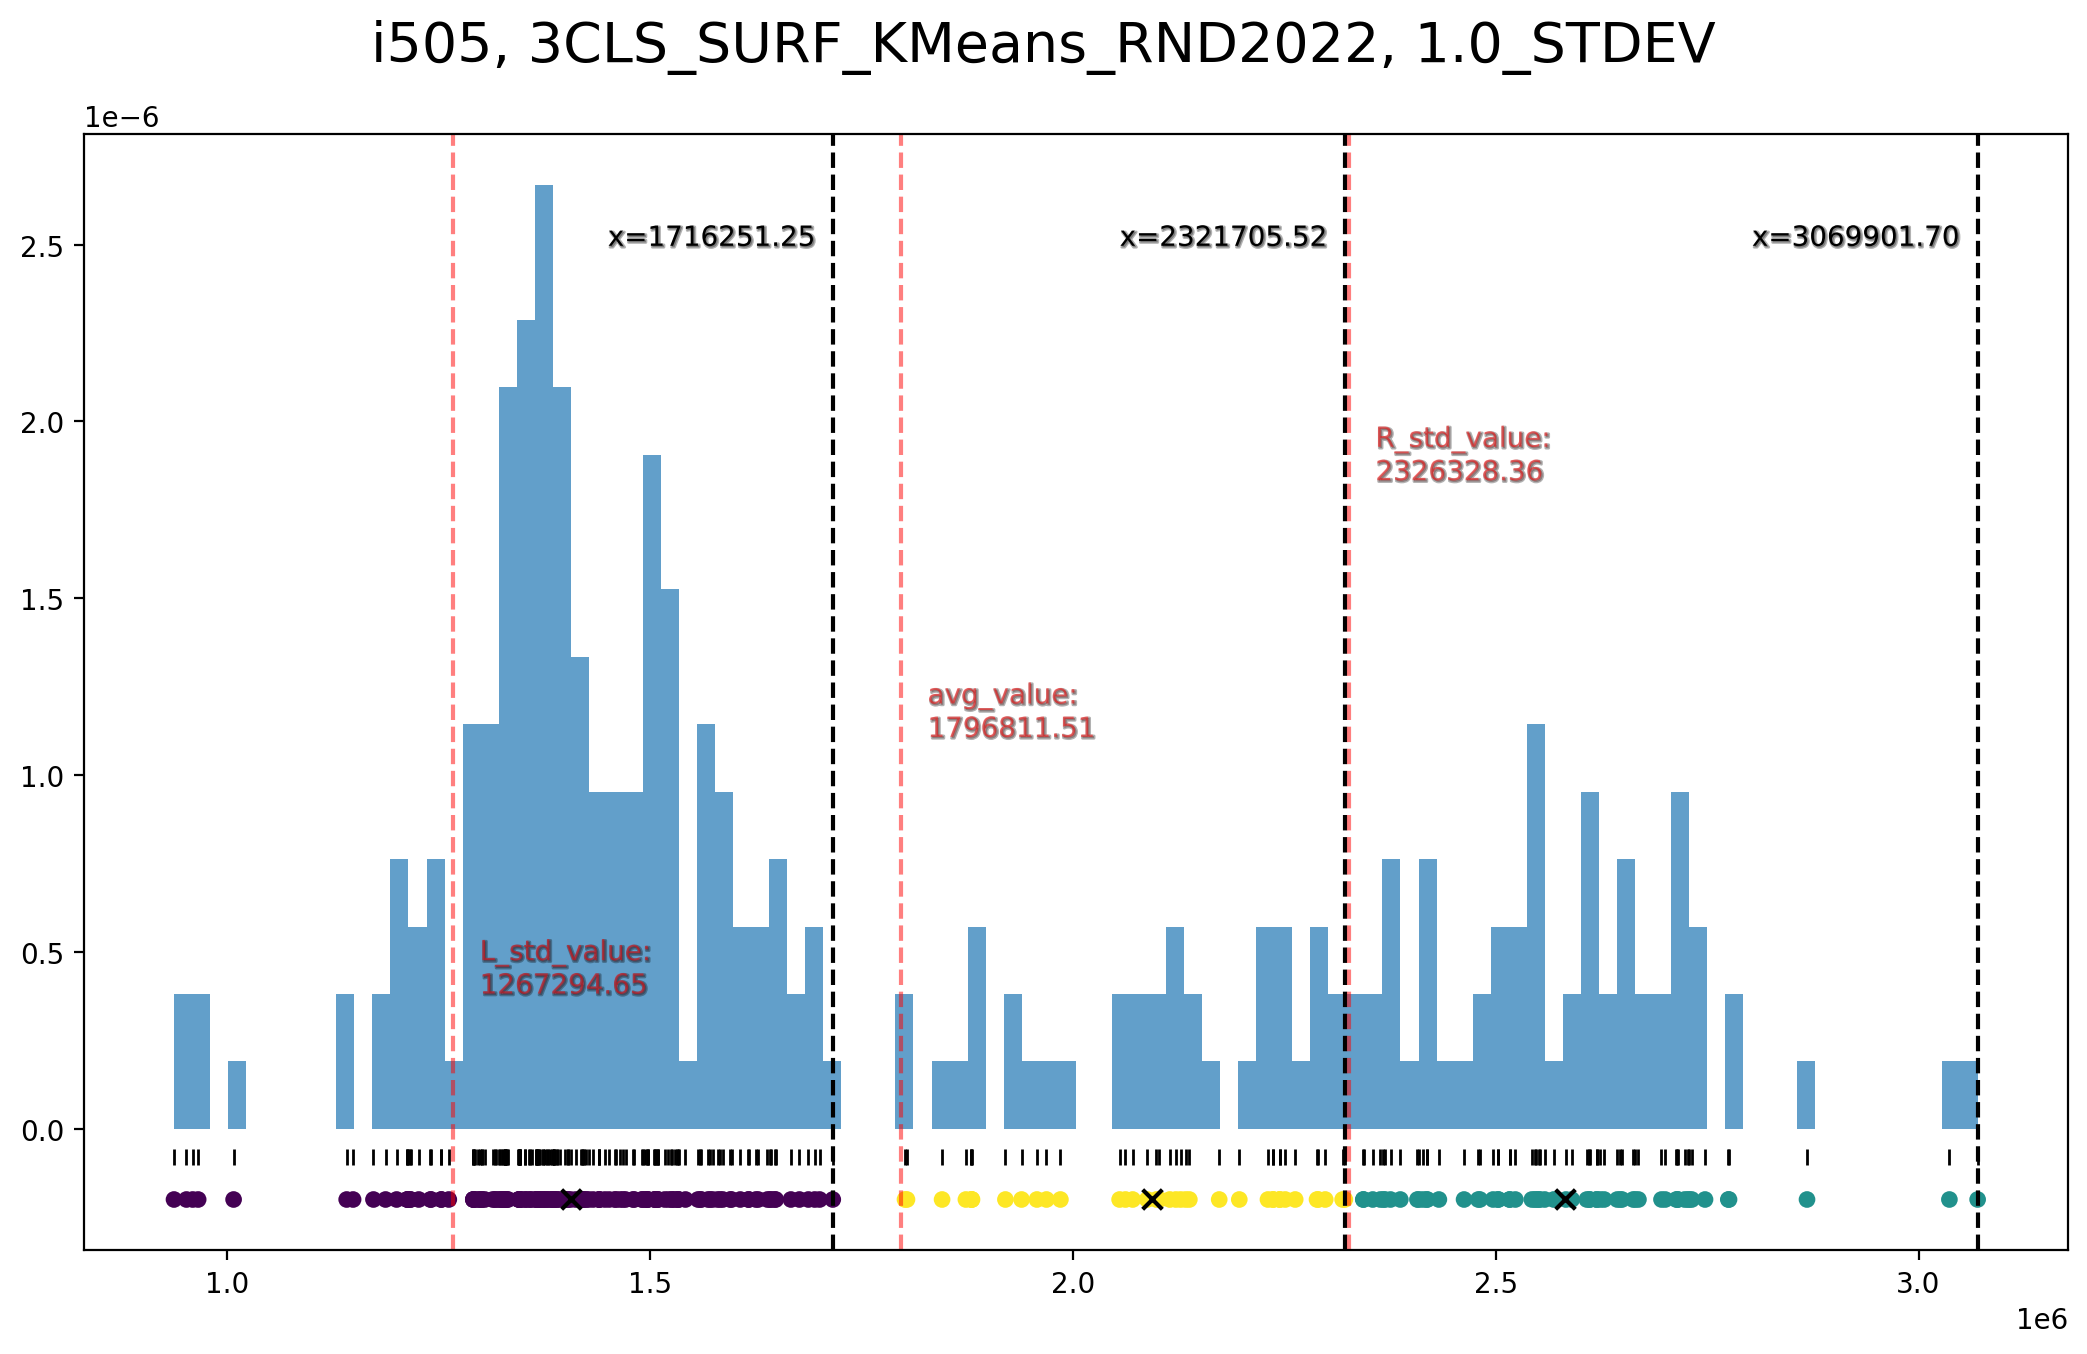

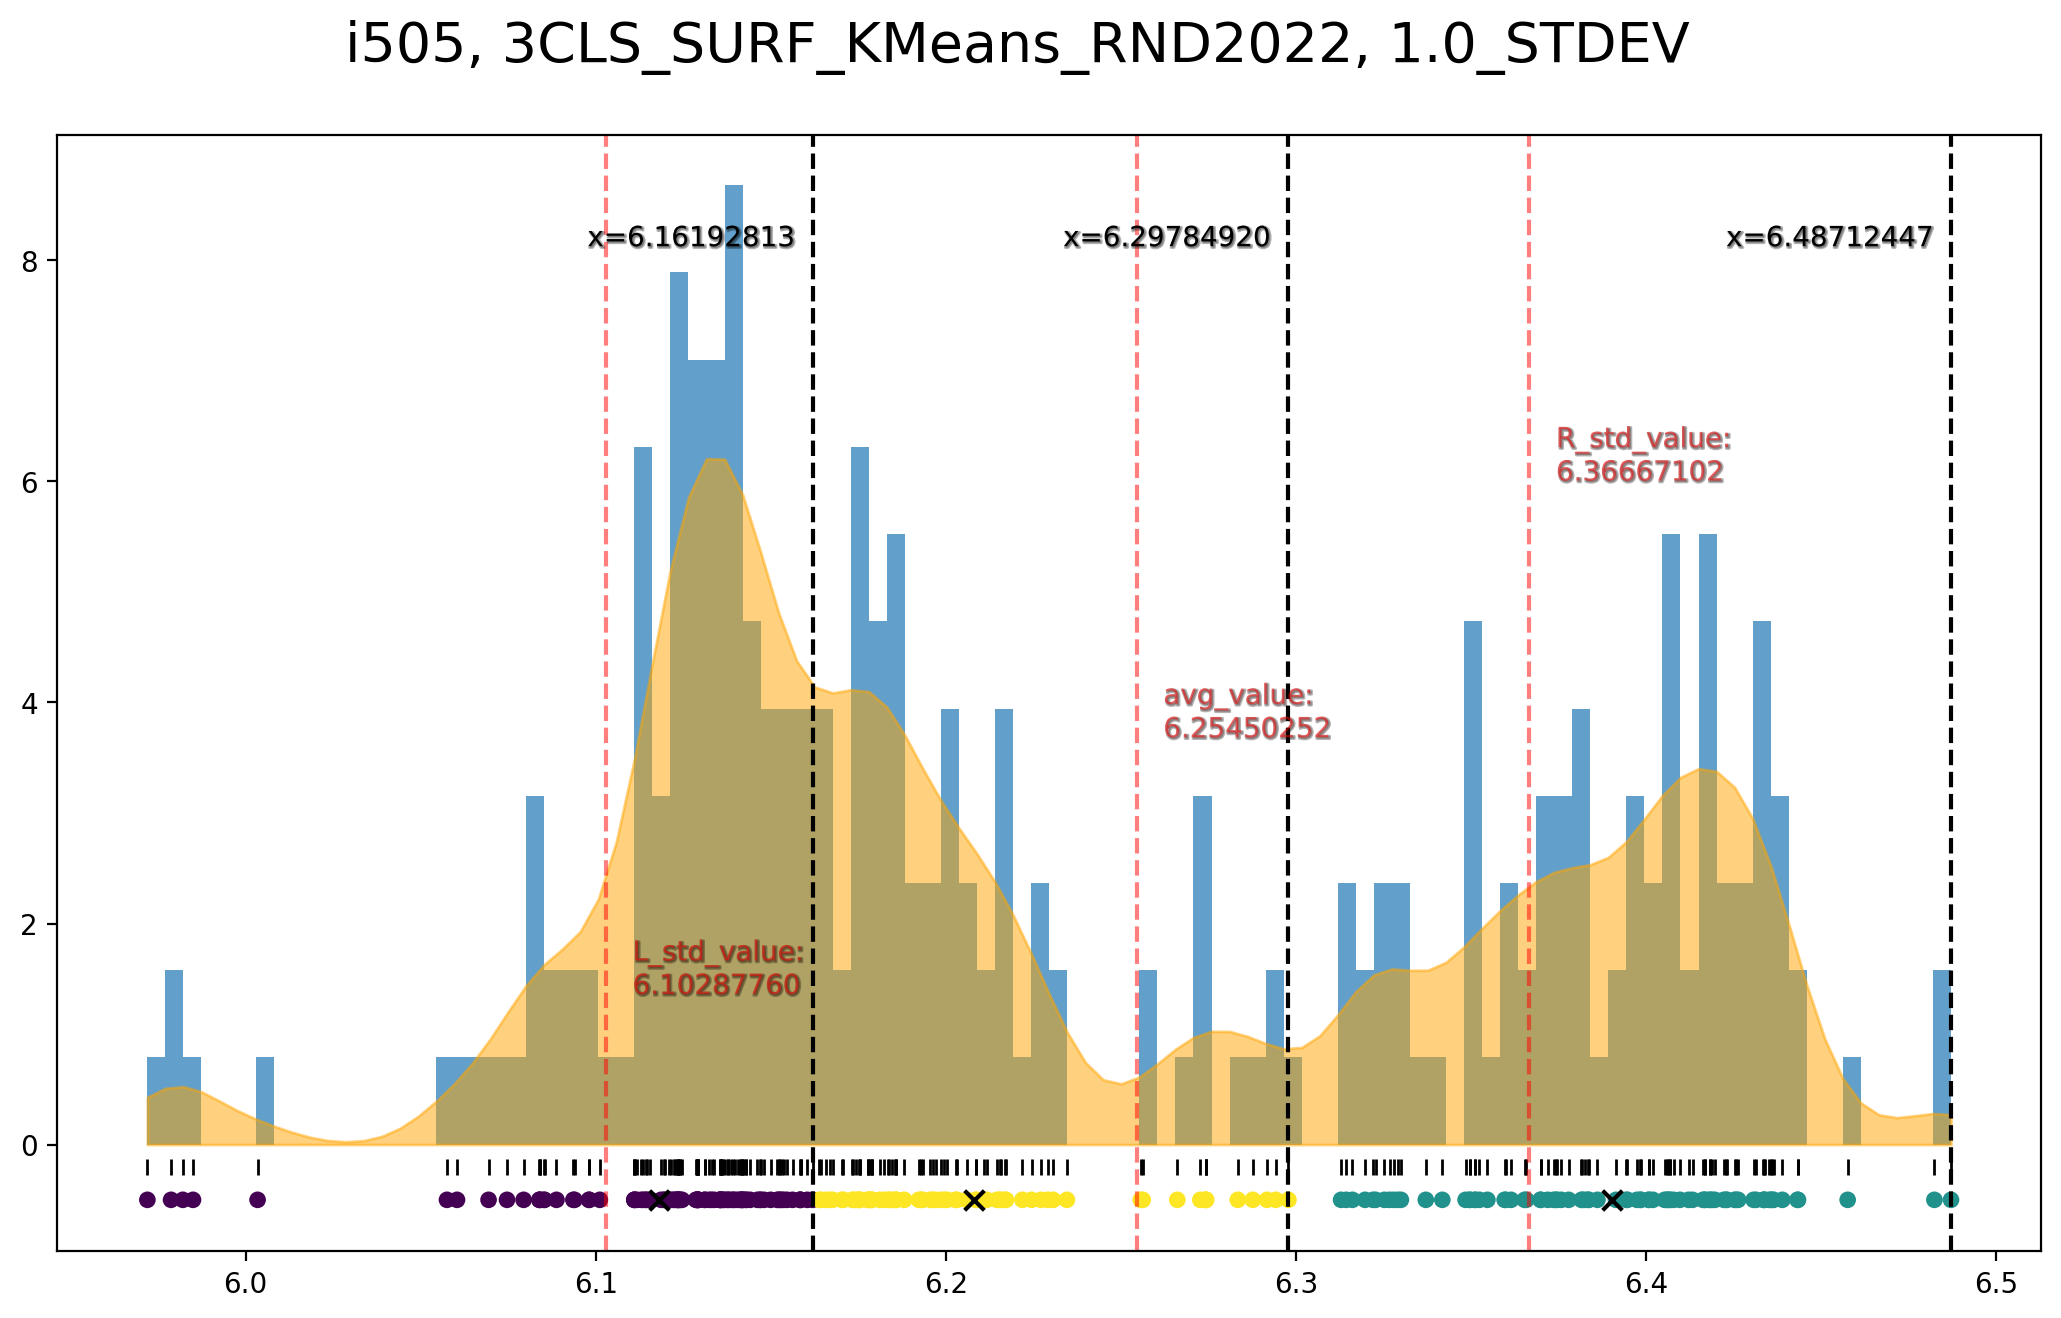

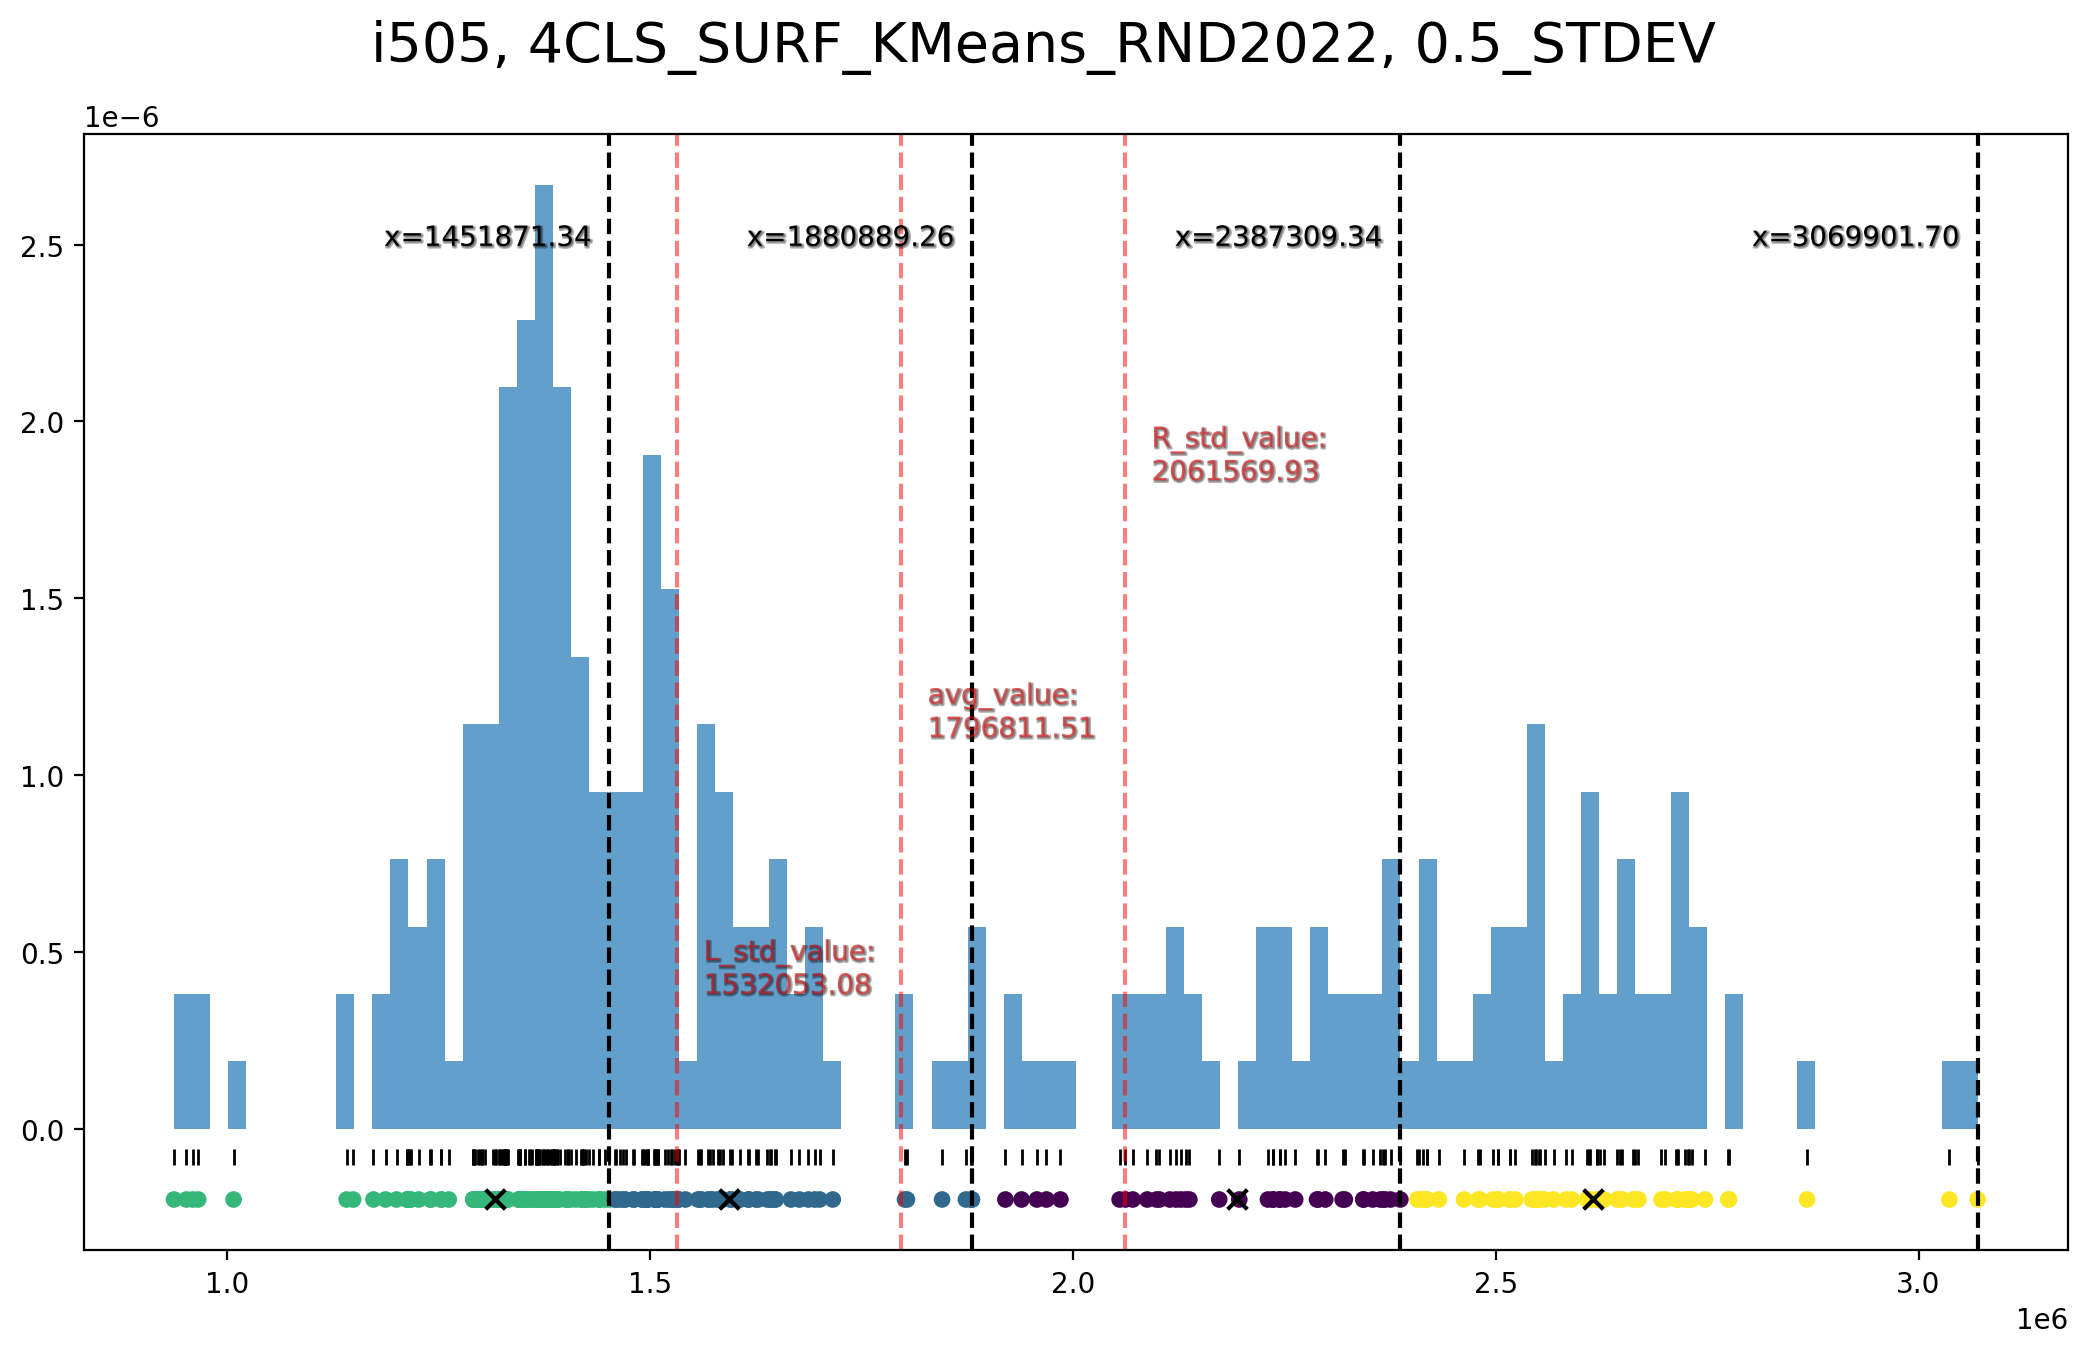

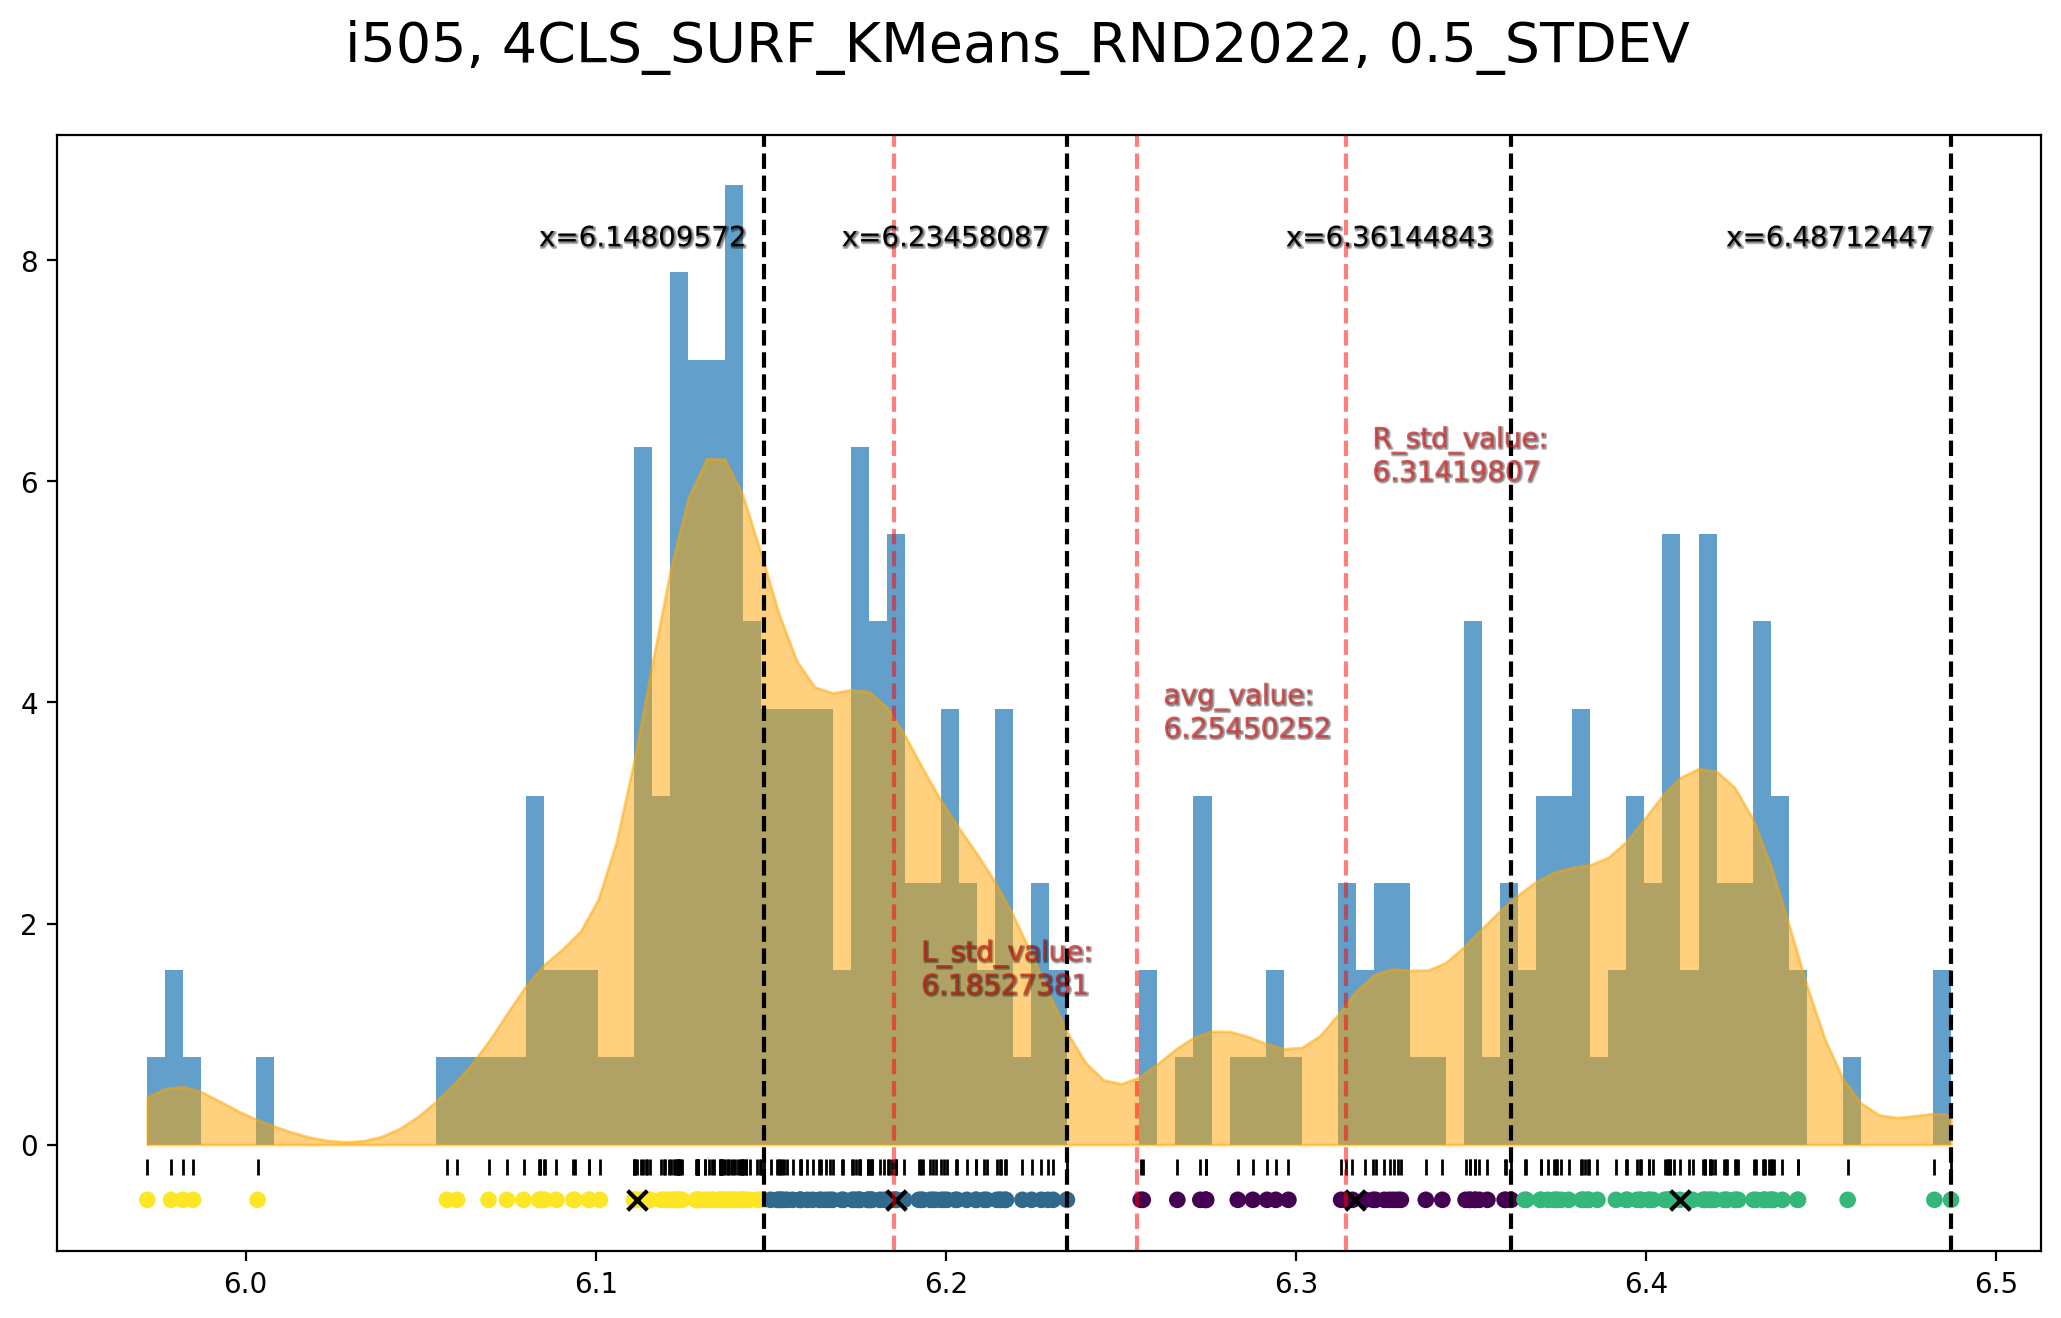

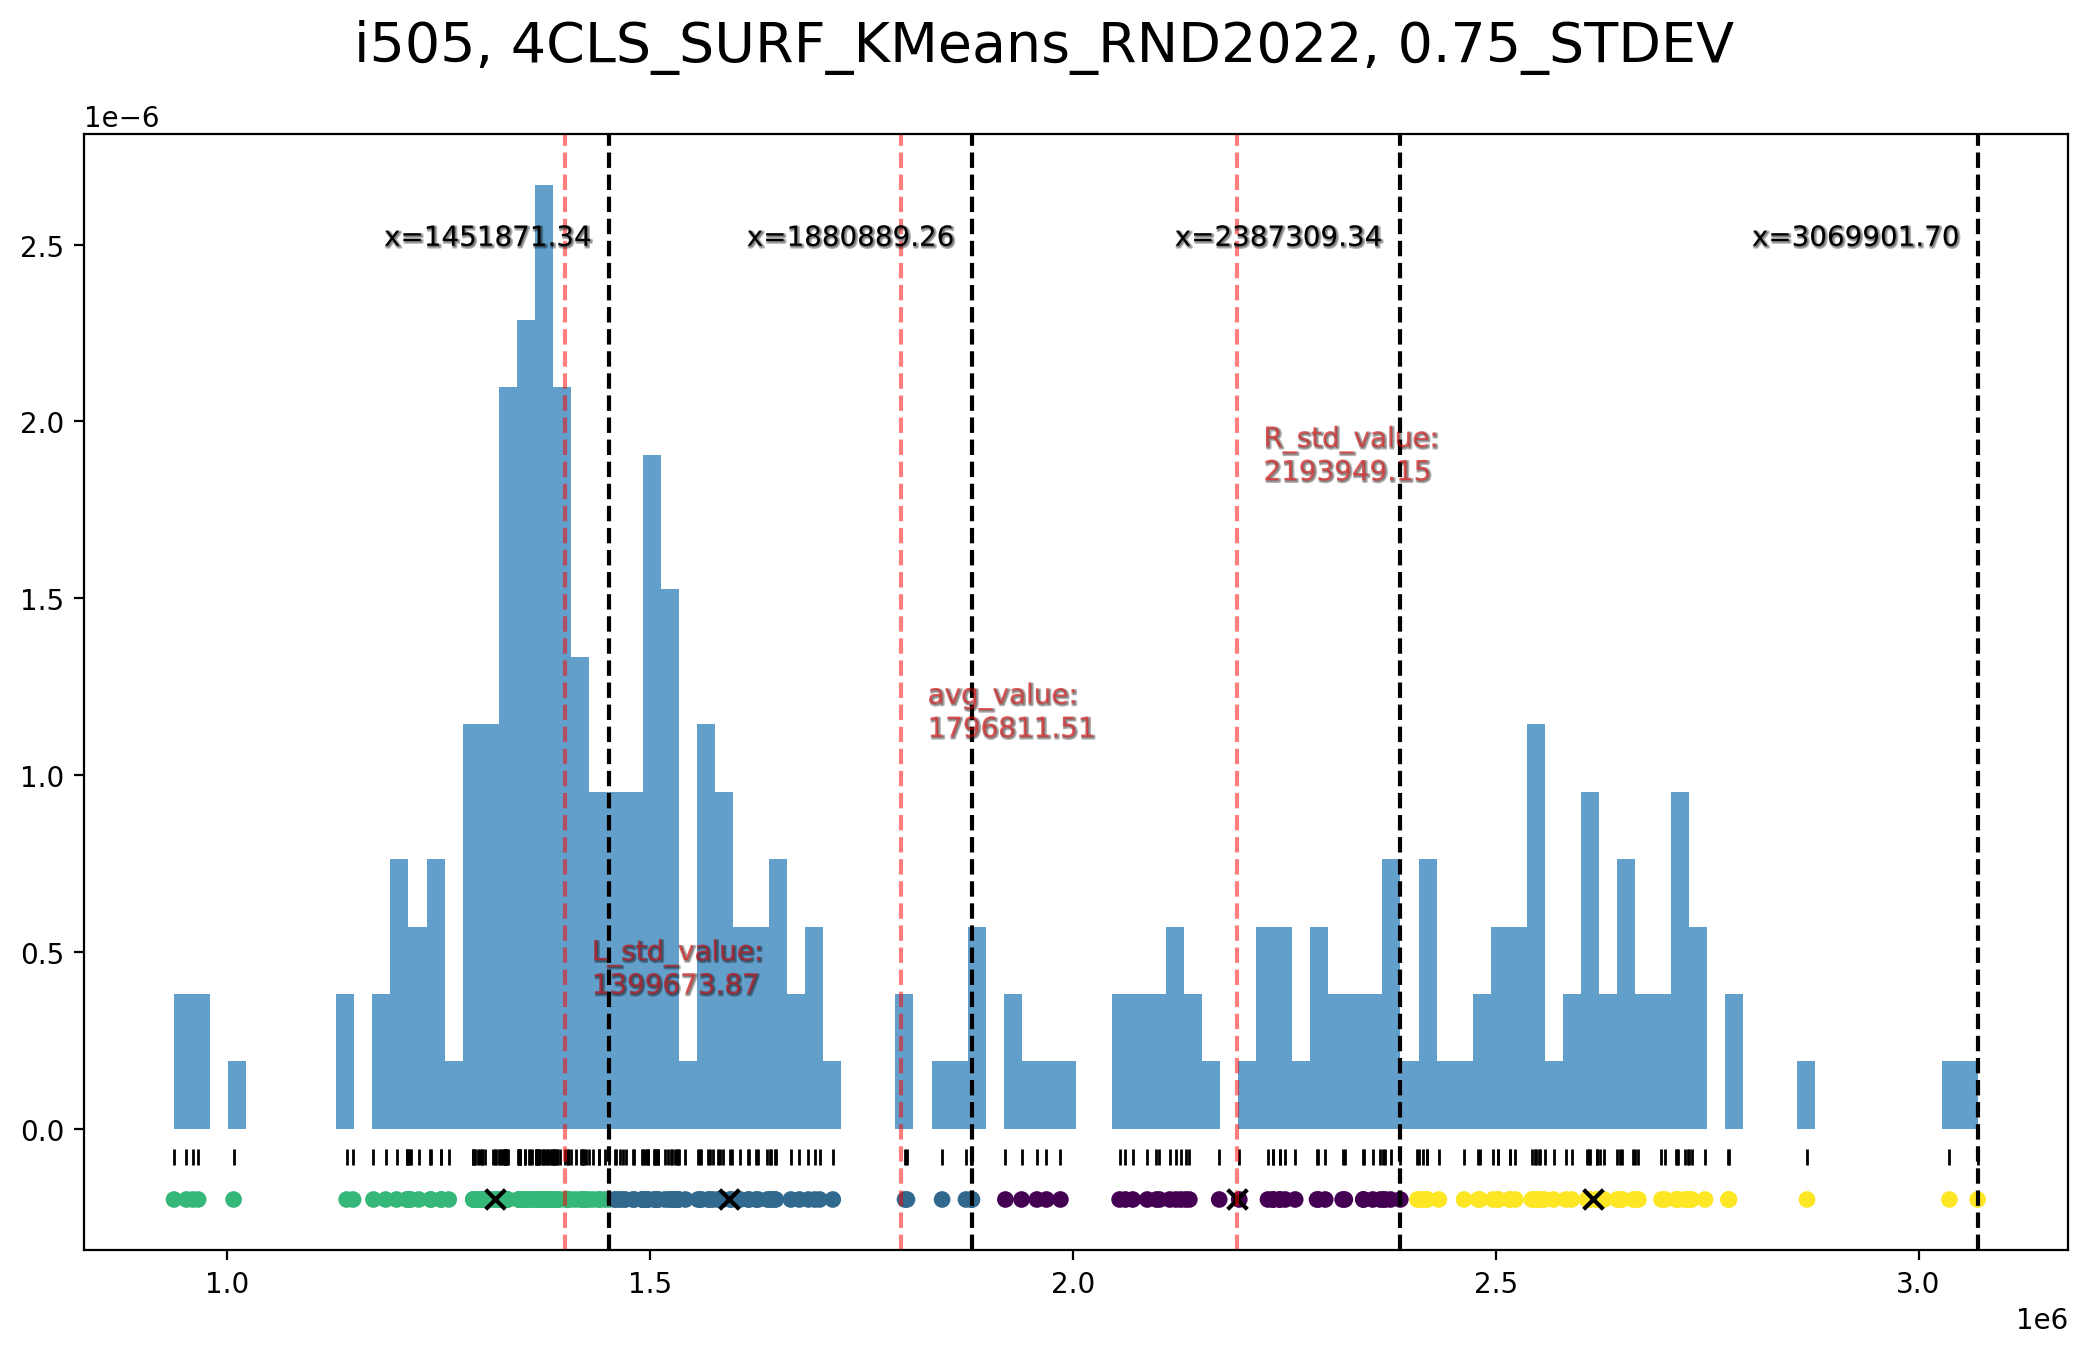

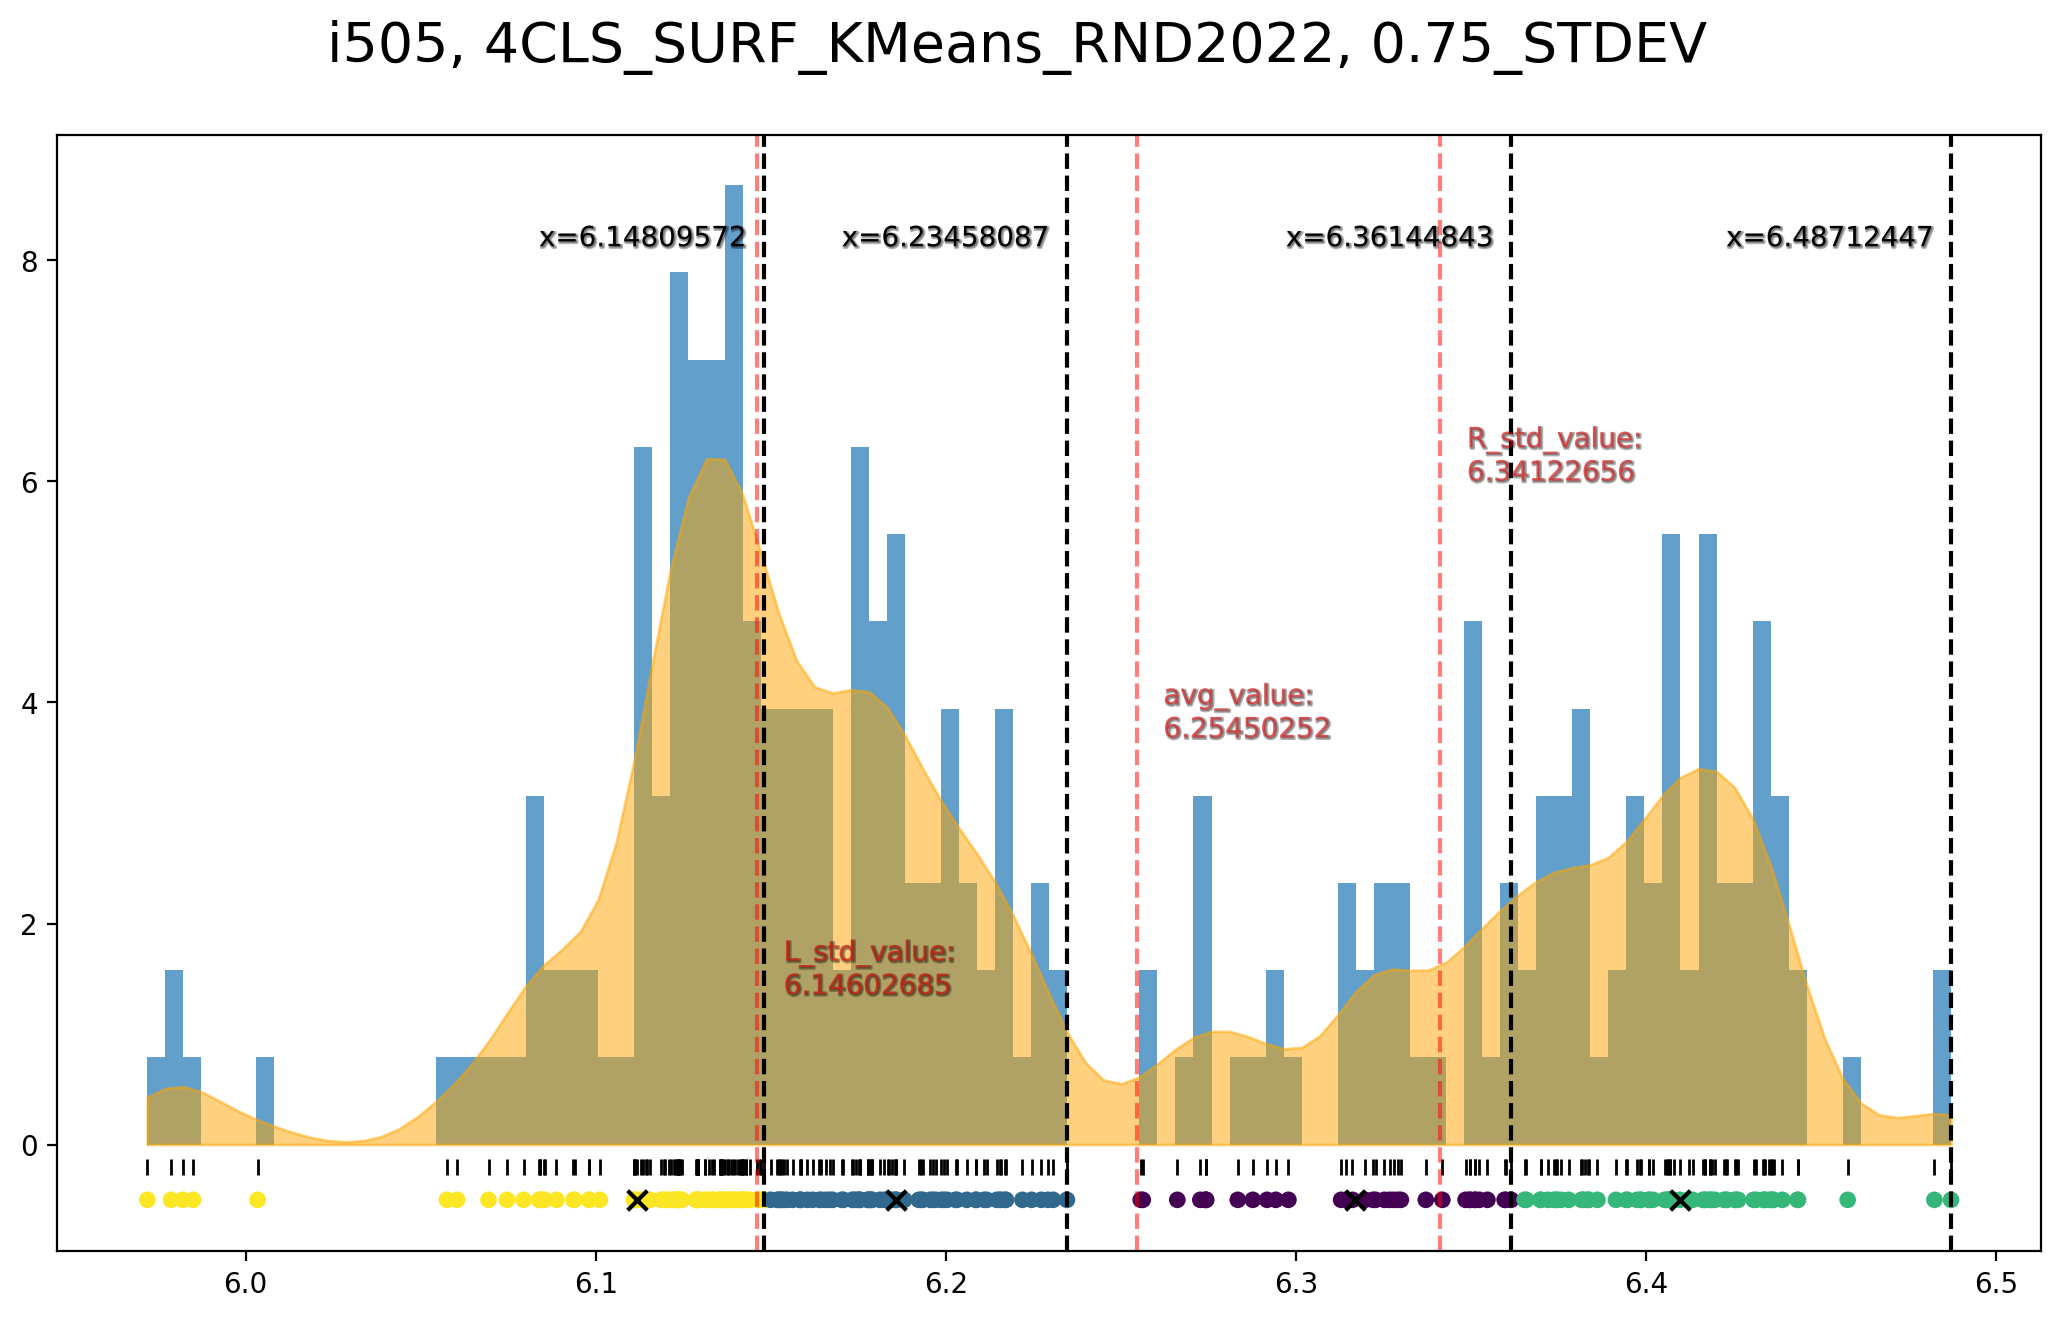

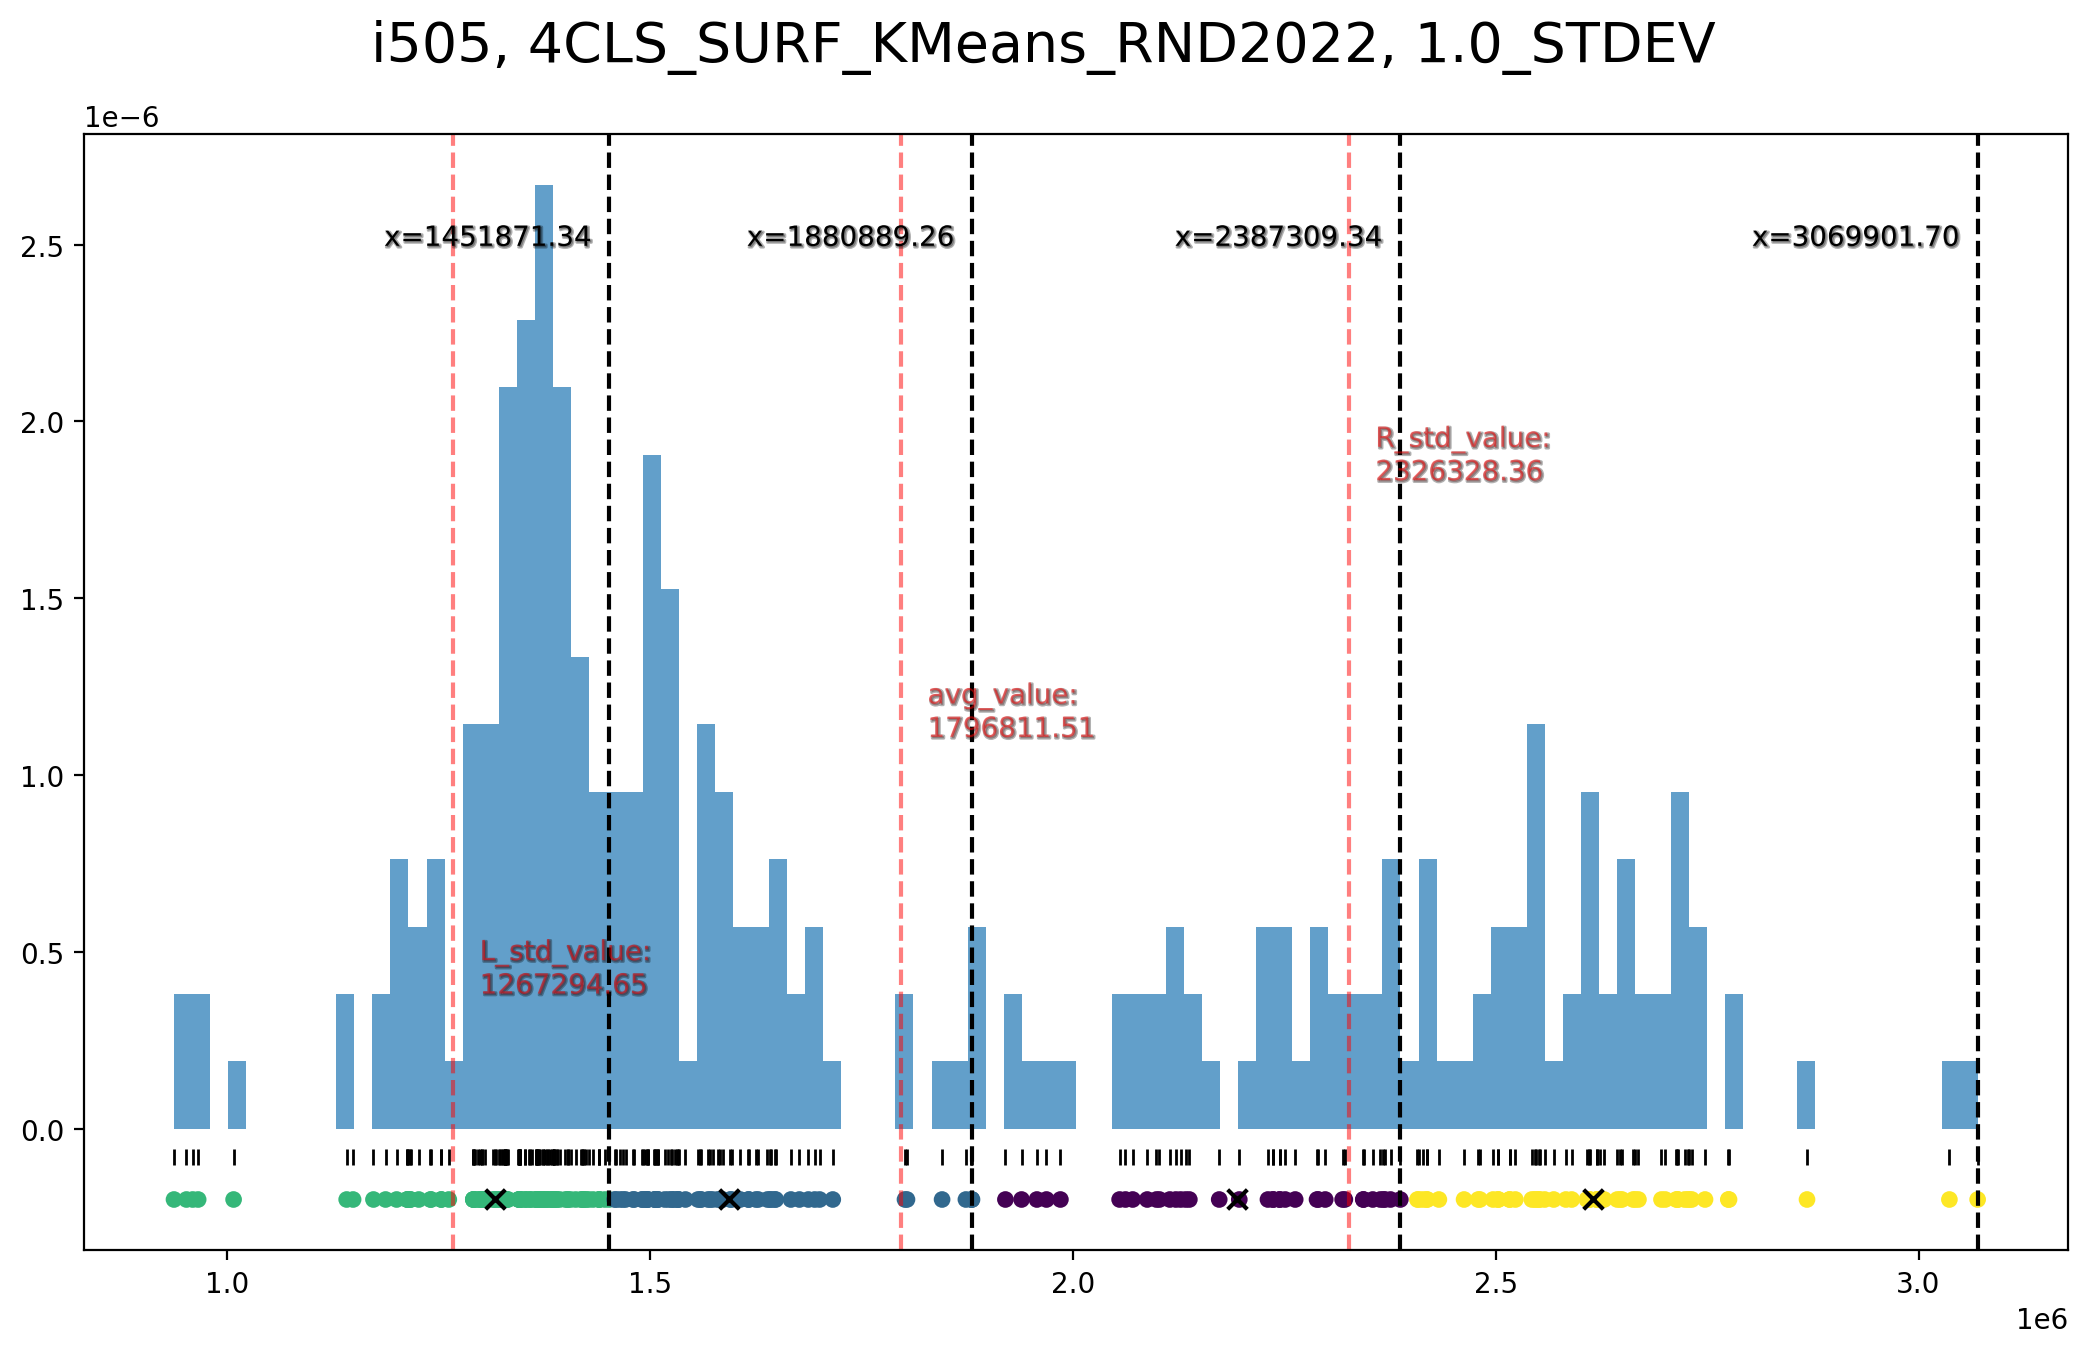

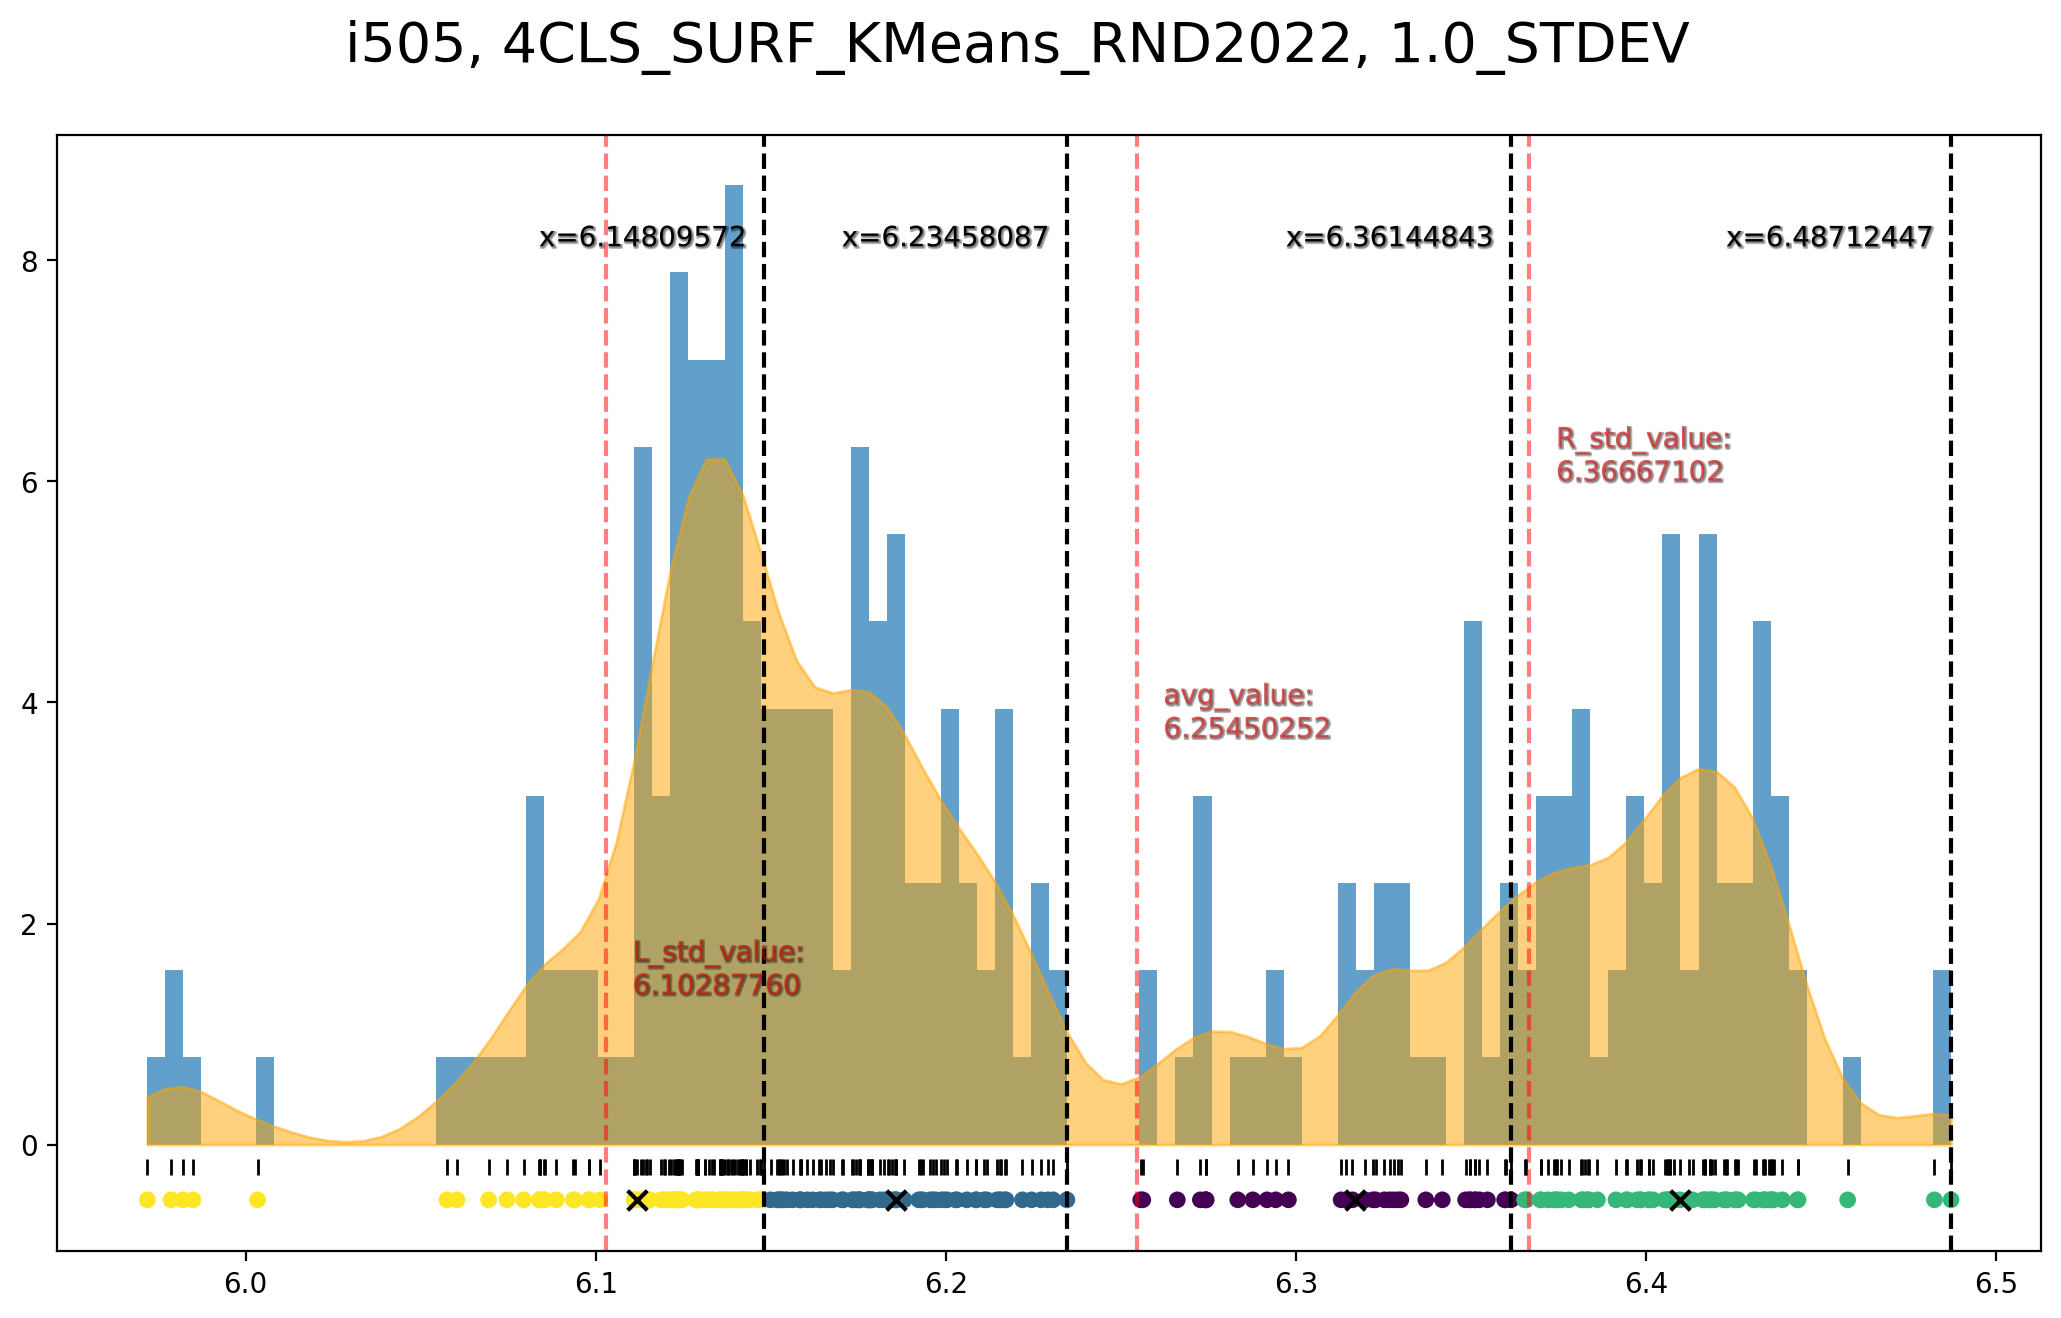

In [3]:
rand_seed = 2022

# -----------------------------------------------------------------------------------

old_i409_3c_path = Path( r"C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\!~OLD_FILE\xlsx\!~BeforeCluster (20230508)\{20230305_NEW_STRUCT}_Academia_Sinica_i409\{Modify}_xlsx\{3CLS_BY_SurfStDev}_data.xlsx" )
n_clusters = 3
label_str_3c = ["S", "M", "L"]
i409_3c_sheet_name = ["0.5_STDEV"]

for sheet_name in i409_3c_sheet_name:
    SAKMeansCluster = SurfaceAreaKMeansCluster(old_i409_3c_path, n_clusters, label_str_3c,
                                               rand_seed, with_kde=False, sheet_name=sheet_name)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.compare_to_old_classdiv()
    
    SAKMeansCluster = SurfaceAreaKMeansCluster(old_i409_3c_path, n_clusters, label_str_3c,
                                               rand_seed, with_kde=True, sheet_name=sheet_name)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.compare_to_old_classdiv()


# -----------------------------------------------------------------------------------

old_i505_3c_path = Path( r"C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\!~OLD_FILE\xlsx\!~BeforeCluster (20230508)\{20230424_Update}_Academia_Sinica_i505\{Modify}_xlsx\{3CLS_BY_SurfStDev}_data.xlsx" )
n_clusters = 3
label_str_3c = ["S", "M", "L"]
i505_3c_sheet_name = ["0.5_STDEV", "0.75_STDEV", "1.0_STDEV"]

for sheet_name in i505_3c_sheet_name:
    SAKMeansCluster = SurfaceAreaKMeansCluster(old_i505_3c_path, n_clusters, label_str_3c,
                                               rand_seed, with_kde=False, sheet_name=sheet_name)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.compare_to_old_classdiv()
    
    SAKMeansCluster = SurfaceAreaKMeansCluster(old_i505_3c_path, n_clusters, label_str_3c,
                                               rand_seed, with_kde=True, sheet_name=sheet_name)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.compare_to_old_classdiv()


# -----------------------------------------------------------------------------------

old_i505_4c_path = Path( r"C:\Users\confocal_microscope\Desktop\WorkingDir\ZebraFish_DB\!~OLD_FILE\xlsx\!~BeforeCluster (20230508)\{20230424_Update}_Academia_Sinica_i505\{Modify}_xlsx\{4CLS_BY_SurfStDev}_data.xlsx" )
n_clusters = 4
label_str_4c = ["S", "M", "L", "XL"]
i505_4c_sheet_name = ["0.5_STDEV", "0.75_STDEV", "1.0_STDEV"]

for sheet_name in i505_4c_sheet_name:
    SAKMeansCluster = SurfaceAreaKMeansCluster(old_i505_4c_path, n_clusters, label_str_4c,
                                               rand_seed, with_kde=False, sheet_name=sheet_name)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.compare_to_old_classdiv()
    
    SAKMeansCluster = SurfaceAreaKMeansCluster(old_i505_4c_path, n_clusters, label_str_4c,
                                               rand_seed, with_kde=True, sheet_name=sheet_name)
    print("="*80, "\n", SAKMeansCluster); SAKMeansCluster.compare_to_old_classdiv()

### `GMM` Method

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 生成具有兩個常態分佈的隨機資料
np.random.seed(0)
x = np.concatenate([np.random.normal(-1, 1, 1000), np.random.normal(1, 1, 1000)])

# 設定 GMM 的參數，使用兩個高斯分佈進行混合
n_components = 2
covariance_type = 'full'
gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=0)

# 對資料進行擬合
gmm.fit(x.reshape(-1, 1))

# 將每個資料點分配到對應的高斯分佈中
labels = gmm.predict(x.reshape(-1, 1))

# 計算每個資料點屬於各個高斯分佈的機率密度值
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

# 繪製資料的直方圖和擬合曲線
fig, ax = plt.subplots()
ax.hist(x, bins=50, density=True, alpha=0.5, color='gray')
for i in range(n_components):
    mask = labels == i
    ax.plot(x, pdf * mask, color='r')
ax.set_xlim(-5, 5)
plt.show()